In [1]:
import os
import re
import nltk
import requests
import warnings
import pandas as pd
import numpy as np
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

from PIL import Image
warnings.filterwarnings('ignore')
from dataprep.eda import plot, plot_correlation, plot_missing, create_report


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Importing Dataset

In [2]:
books = pd.read_csv('Books.csv')
books

ISBN                                         Book-Title  \
0       0195153448                                Classical Mythology   
1       0002005018                                       Clara Callan   
2       0060973129                               Decision in Normandy   
3       0374157065  Flu: The Story of the Great Influenza Pandemic...   
4       0393045218                             The Mummies of Urumchi   
...            ...                                                ...   
271355  0440400988                         There's a Bat in Bunk Five   
271356  0525447644                            From One to One Hundred   
271357  006008667X  Lily Dale : The True Story of the Town that Ta...   
271358  0192126040                        Republic (World's Classics)   
271359  0767409752  A Guided Tour of Rene Descartes' Meditations o...   

                 Book-Author Year-Of-Publication  \
0         Mark P. O. Morford                2002   
1       Richard Bruce Wright                2001   
2               Carlo D'Este                1991   
3           Gina Bari Kolata                1999   
4            E. J. W. Barber                1999   
...                      ...                 ...   
271355        Paula Danziger                1988   
271356            Teri Sloat                1991   
271357      Christine Wicker                2004   
271358                 Plato                1996   
271359   Christopher  Biffle                2000   

                                               Publisher  \
0                                Oxford University Press   
1                                  HarperFlamingo Canada   
2                                        HarperPerennial   
3                                   Farrar Straus Giroux   
4                             W. W. Norton &amp; Company   
...                                                  ...   
271355                   Random House Childrens Pub (Mm)   
271356                                      Dutton Books   
271357                                HarperSanFrancisco   
271358                           Oxford University Press   
271359  McGraw-Hill Humanities/Social Sciences/Languages   

                                              Image-URL-S  \
0       http://images.amazon.com/images/P/0195153448.0...   
1       http://images.amazon.com/images/P/0002005018.0...   
2       http://images.amazon.com/images/P/0060973129.0...   
3       http://images.amazon.com/images/P/0374157065.0...   
4       http://images.amazon.com/images/P/0393045218.0...   
...                                                   ...   
271355  http://images.amazon.com/images/P/0440400988.0...   
271356  http://images.amazon.com/images/P/0525447644.0...   
271357  http://images.amazon.com/images/P/006008667X.0...   
271358  http://images.amazon.com/images/P/0192126040.0...   
271359  http://images.amazon.com/images/P/0767409752.0...   

                                              Image-URL-M  \
0       http://images.amazon.com/images/P/0195153448.0...   
1       http://images.amazon.com/images/P/0002005018.0...   
2       http://images.amazon.com/images/P/0060973129.0...   
3       http://images.amazon.com/images/P/0374157065.0...   
4       http://images.amazon.com/images/P/0393045218.0...   
...                                                   ...   
271355  http://images.amazon.com/images/P/0440400988.0...   
271356  http://images.amazon.com/images/P/0525447644.0...   
271357  http://images.amazon.com/images/P/006008667X.0...   
271358  http://images.amazon.com/images/P/0192126040.0...   
271359  http://images.amazon.com/images/P/0767409752.0...   

                                              Image-URL-L  
0       http://images.amazon.com/images/P/0195153448.0...  
1       http://images.amazon.com/images/P/0002005018.0...  
2       http://images.amazon.com/images/P/0060973129.0...  
3       http://images.amazon.com/images/P/0374157065.0...  
4       http://images.ama

In [3]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [4]:
rating = pd.read_csv("Ratings.csv")
rating

User-ID         ISBN  Book-Rating
0         276725   034545104X            0
1         276726   0155061224            5
2         276727   0446520802            0
3         276729   052165615X            3
4         276729   0521795028            6
...          ...          ...          ...
1149775   276704   1563526298            9
1149776   276706   0679447156            0
1149777   276709   0515107662           10
1149778   276721   0590442449           10
1149779   276723  05162443314            8

[1149780 rows x 3 columns]

In [5]:
users = pd.read_csv("Users.csv")
users

User-ID                            Location   Age
0             1                  nyc, new york, usa   NaN
1             2           stockton, california, usa  18.0
2             3     moscow, yukon territory, russia   NaN
3             4           porto, v.n.gaia, portugal  17.0
4             5  farnborough, hants, united kingdom   NaN
...         ...                                 ...   ...
278853   278854               portland, oregon, usa   NaN
278854   278855  tacoma, washington, united kingdom  50.0
278855   278856           brampton, ontario, canada   NaN
278856   278857           knoxville, tennessee, usa   NaN
278857   278858                dublin, n/a, ireland   NaN

[278858 rows x 3 columns]

In [6]:
# Merge the datasets using common columns
data = pd.merge(books, rating, on='ISBN')

In [7]:
data


ISBN                                         Book-Title  \
0        0195153448                                Classical Mythology   
1        0002005018                                       Clara Callan   
2        0002005018                                       Clara Callan   
3        0002005018                                       Clara Callan   
4        0002005018                                       Clara Callan   
...             ...                                                ...   
1031131  0440400988                         There's a Bat in Bunk Five   
1031132  0525447644                            From One to One Hundred   
1031133  006008667X  Lily Dale : The True Story of the Town that Ta...   
1031134  0192126040                        Republic (World's Classics)   
1031135  0767409752  A Guided Tour of Rene Descartes' Meditations o...   

                  Book-Author Year-Of-Publication  \
0          Mark P. O. Morford                2002   
1        Richard Bruce Wright                2001   
2        Richard Bruce Wright                2001   
3        Richard Bruce Wright                2001   
4        Richard Bruce Wright                2001   
...                       ...                 ...   
1031131        Paula Danziger                1988   
1031132            Teri Sloat                1991   
1031133      Christine Wicker                2004   
1031134                 Plato                1996   
1031135   Christopher  Biffle                2000   

                                                Publisher  \
0                                 Oxford University Press   
1                                   HarperFlamingo Canada   
2                                   HarperFlamingo Canada   
3                                   HarperFlamingo Canada   
4                                   HarperFlamingo Canada   
...                                                   ...   
1031131                   Random House Childrens Pub (Mm)   
1031132                                      Dutton Books   
1031133                                HarperSanFrancisco   
1031134                           Oxford University Press   
1031135  McGraw-Hill Humanities/Social Sciences/Languages   

                                               Image-URL-S  \
0        http://images.amazon.com/images/P/0195153448.0...   
1        http://images.amazon.com/images/P/0002005018.0...   
2        http://images.amazon.com/images/P/0002005018.0...   
3        http://images.amazon.com/images/P/0002005018.0...   
4        http://images.amazon.com/images/P/0002005018.0...   
...                                                    ...   
1031131  http://images.amazon.com/images/P/0440400988.0...   
1031132  http://images.amazon.com/images/P/0525447644.0...   
1031133  http://images.amazon.com/images/P/006008667X.0...   
1031134  http://images.amazon.com/images/P/0192126040.0...   
1031135  http://images.amazon.com/images/P/0767409752.0...   

                                               Image-URL-M  \
0        http://images.amazon.com/images/P/0195153448.0...   
1        http://images.amazon.com/images/P/0002005018.0...   
2        http://images.amazon.com/images/P/0002005018.0...   
3        http://images.amazon.com/images/P/0002005018.0...   
4        http://images.amazon.com/images/P/0002005018.0...   
...                                                    ...   
1031131  http://images.amazon.com/images/P/0440400988.0...   
1031132  http://images.amazon.com/images/P/0525447644.0...   
1031133  http://images.amazon.com/images/P/006008667X.0...   
1031134  http://images.amazon.com/images/P/0192126040.0...   
1031135  http://images.amazon.com/images/P/0767409752.0...   

                                               Image-URL-L  User-ID  \
0        http://images.amazon.com/images/P/0195153448.0...        2   
1        http://images.amazon.com/images/P/0002005018.0...        8   
2        http://images.amazon.com/images/P/0002005018

In [8]:
Data = pd.merge(data, users, on='User-ID')
Data.to_csv('Data.csv',index=False)
Data

ISBN                                         Book-Title  \
0        0195153448                                Classical Mythology   
1        0002005018                                       Clara Callan   
2        0060973129                               Decision in Normandy   
3        0374157065  Flu: The Story of the Great Influenza Pandemic...   
4        0393045218                             The Mummies of Urumchi   
...             ...                                                ...   
1031131  087004124X                                             Anthem   
1031132  158243123X                               A Student of Weather   
1031133  8485900057            Rimas y leyendas (ClÃ¡sicos Fraile ; 3)   
1031134  0838934854                   Anglo-American Cataloguing Rules   
1031135  3423300965                                   Texte zur Ethik.   

                     Book-Author Year-Of-Publication  \
0             Mark P. O. Morford                2002   
1           Richard Bruce Wright                2001   
2                   Carlo D'Este                1991   
3               Gina Bari Kolata                1999   
4                E. J. W. Barber                1999   
...                          ...                 ...   
1031131                 Ayn Rand                1966   
1031132            Elizabeth Hay                2001   
1031133  Gustavo Adolfo BÃ©cquer                1981   
1031134           Michael Gorman                1998   
1031135        Dieter Birnbacher                2003   

                            Publisher  \
0             Oxford University Press   
1               HarperFlamingo Canada   
2                     HarperPerennial   
3                Farrar Straus Giroux   
4          W. W. Norton &amp; Company   
...                               ...   
1031131                  Caxton Press   
1031132            Counterpoint Press   
1031133              Ediciones Fraile   
1031134  American Library Association   
1031135                           Dtv   

                                               Image-URL-S  \
0        http://images.amazon.com/images/P/0195153448.0...   
1        http://images.amazon.com/images/P/0002005018.0...   
2        http://images.amazon.com/images/P/0060973129.0...   
3        http://images.amazon.com/images/P/0374157065.0...   
4        http://images.amazon.com/images/P/0393045218.0...   
...                                                    ...   
1031131  http://images.amazon.com/images/P/087004124X.0...   
1031132  http://images.amazon.com/images/P/158243123X.0...   
1031133  http://images.amazon.com/images/P/8485900057.0...   
1031134  http://images.amazon.com/images/P/0838934854.0...   
1031135  http://images.amazon.com/images/P/3423300965.0...   

                                               Image-URL-M  \
0        http://images.amazon.com/images/P/0195153448.0...   
1        http://images.amazon.com/images/P/0002005018.0...   
2        http://images.amazon.com/images/P/0060973129.0...   
3        http://images.amazon.com/images/P/0374157065.0...   
4        http://images.amazon.com/images/P/0393045218.0...   
...                                                    ...   
1031131  http://images.amazon.com/images/P/087004124X.0...   
1031132  http://images.amazon.com/images/P/158243123X.0...   
1031133  http://images.amazon.com/images/P/8485900057.0...   
1031134  http://images.amazon.com/images/P/0838934854.0...   
1031135  http://images.amazon.com/images/P/3423300965.0...   

                                               Image-URL-L  User-ID  \
0        http://images.amazon.com/images/P/0195153448.0...        2   
1        http://images.amazon.com/images/P/0002005018.0...        8   
2        http://images.amazon.com/images/P/0060973129.0...        8   
3        http://images.amazon.com/images/P/0374157065.0...        8   
4        http://images.amazon.com/images/P/0393045218.0...        8   
...                                         

In [9]:
Data.isnull().sum()

ISBN                        0
Book-Title                  0
Book-Author                 1
Year-Of-Publication         0
Publisher                   2
Image-URL-S                 0
Image-URL-M                 0
Image-URL-L                 4
User-ID                     0
Book-Rating                 0
Location                    0
Age                    277835
dtype: int64

In [10]:
# drop null values
Data.dropna(subset=['Age','Book-Author','Publisher','Image-URL-L'], inplace=True)

In [11]:
# verify that null values are dropped
print(Data.isnull().sum())

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
User-ID                0
Book-Rating            0
Location               0
Age                    0
dtype: int64


In [12]:
len(Data.ISBN.unique())

228996

In [13]:
#Unique reader count
Data["User-ID"].nunique()

53887

In [14]:
Data["Book-Rating"].describe()

count    753296.000000
mean          2.768896
std           3.864231
min           0.000000
25%           0.000000
50%           0.000000
75%           7.000000
max          10.000000
Name: Book-Rating, dtype: float64

In [15]:
#Removing books with zero ratings from the data set
Data[Data["Book-Rating"]==0]

ISBN                                         Book-Title  \
0        0195153448                                Classical Mythology   
18       0002005018                                       Clara Callan   
21       0671021001              She's Come Undone (Oprah's Book Club)   
23       0446364193            Along Came a Spider (Alex Cross Novels)   
25       0440211727                                     A Time to Kill   
...             ...                                                ...   
1031113  0821731424                                             Thrill   
1031118  345386431X                                   Zeit ohne Worte.   
1031120  2894293275                                  Kitchen Companion   
1031121  3593358069  Die Entscheidung liegt bei dir. Wege aus der a...   
1031122  8806151681                                 Lessico Famigliare   

                  Book-Author Year-Of-Publication                 Publisher  \
0          Mark P. O. Morford                2002   Oxford University Press   
18       Richard Bruce Wright                2001     HarperFlamingo Canada   
21                 Wally Lamb                1998                    Pocket   
23            James Patterson                1993              Warner Books   
25               JOHN GRISHAM                1992                      Dell   
...                       ...                 ...                       ...   
1031113      Patricia Wallace                1990               Zebra Books   
1031118     Catherine Cookson                2003                     Heyne   
1031120          Wendy Hobson                1992  Tormont Publications Inc   
1031121  Reinhard K. Sprenger                2002           Campus Sachbuch   
1031122      Natalia Ginzburg                1963                   Einaudi   

                                               Image-URL-S  \
0        http://images.amazon.com/images/P/0195153448.0...   
18       http://images.amazon.com/images/P/0002005018.0...   
21       http://images.amazon.com/images/P/0671021001.0...   
23       http://images.amazon.com/images/P/0446364193.0...   
25       http://images.amazon.com/images/P/0440211727.0...   
...                                                    ...   
1031113  http://images.amazon.com/images/P/0821731424.0...   
1031118  http://images.amazon.com/images/P/345386431X.0...   
1031120  http://images.amazon.com/images/P/2894293275.0...   
1031121  http://images.amazon.com/images/P/3593358069.0...   
1031122  http://images.amazon.com/images/P/8806151681.0...   

                                               Image-URL-M  \
0        http://images.amazon.com/images/P/0195153448.0...   
18       http://images.amazon.com/images/P/0002005018.0...   
21       http://images.amazon.com/images/P/0671021001.0...   
23       http://images.amazon.com/images/P/0446364193.0...   
25       http://images.amazon.com/images/P/0440211727.0...   
...                                                    ...   
1031113  http://images.amazon.com/images/P/0821731424.0...   
1031118  http://images.amazon.com/images/P/345386431X.0...   
1031120  http://images.amazon.com/images/P/2894293275.0...   
1031121  http://images.amazon.com/images/P/3593358069.0...   
1031122  http://images.amazon.com/images/P/8806151681.0...   

                                               Image-URL-L  User-ID  \
0        http://images.amazon.com/images/P/0195153448.0...        2   
18       http://images.amazon.com/images/P/0002005018.0...    11400   
21       http://images.amazon.com/images/P/0671021001.0...    11400   
23       http://images.amazon.com/images/P/0446364193.0...    11400   
25       http://images.amazon.com/images/P/0440211727.0...    11400   
...                                                    ...      ...   
1031113  http://images.amazon.com/images/P/0821731424.0...   243649   
1031118  http://images.amazon.com/images/P/345386431X.0...   244667   
1031120  http://images.amazon.com/images/P/28942

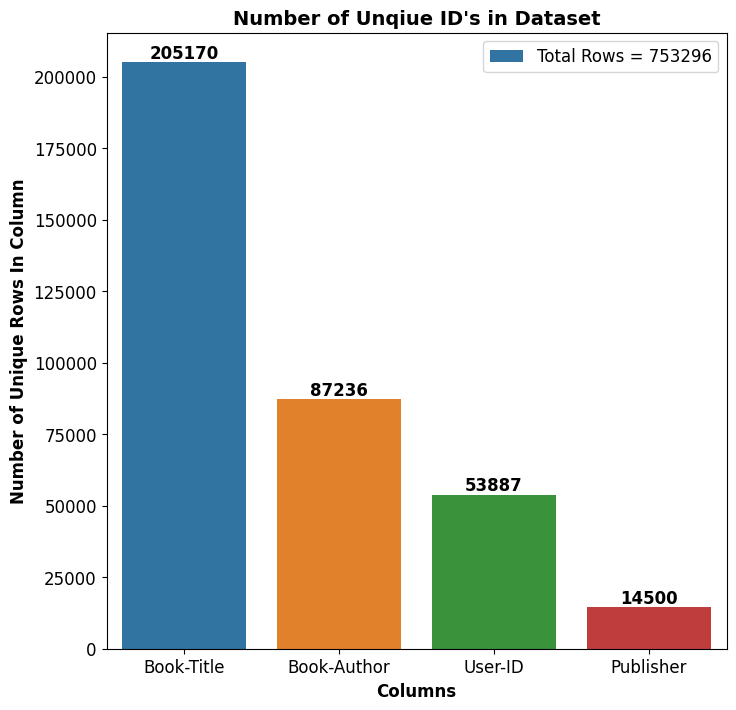

In [16]:
f, axe = plt.subplots(1,1, figsize=(8,8), dpi=100)
ax = sns.barplot(x=['Book-Title','Book-Author',"User-ID",'Publisher'], y=[len(Data['Book-Title'].unique()),len(Data['Book-Author'].unique()),len(Data['User-ID'].unique()),len(Data['Publisher'].unique())], ax = axe
            ,label='Total Rows = {}'.format(len(Data)))
axe.set_xlabel('Columns', size=12,fontweight = 'bold')
axe.set_ylabel('Number of Unique Rows In Column', size=12,fontweight = 'bold')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(loc='best', fontsize  = 'large')
plt.title("Number of Unqiue ID's in Dataset", fontsize = 14, fontweight = 'bold')
for i in ax.containers:
    ax.bar_label(i,color = 'black', fontweight = 'bold', fontsize= 12)
plt.show()

In [17]:
ratings = pd.DataFrame(Data.groupby('Book-Title')['Book-Rating'].mean())
ratings.rename({'Book-Rating':'Mean Ratings'}, axis=1 , inplace =True)
ratings['No of times Rated'] = pd.DataFrame(Data.groupby('Book-Title')['Book-Rating'].count())
ratings

Mean Ratings  \
Book-Title                                                         
 A Light in the Storm: The Civil War Diary of A...      0.000000   
 Always Have Popsicles                                  0.000000   
 Apple Magic (The Collector's series)                   0.000000   
 Ask Lily (Young Women of Faith: Lily Series, B...      8.000000   
 Dark Justice                                          10.000000   
...                                                          ...   
Ã?Â?lpiraten.                                           0.000000   
Ã?Â?rger mit Produkt X. Roman.                          5.250000   
Ã?Â?sterlich leben.                                     7.000000   
Ã?Â?stlich der Berge.                                   2.666667   
Ã?Â?thique en toc                                       4.000000   

                                                    No of times Rated  
Book-Title                                                             
 A Light in the Storm: The Civil War Diary of A...                  1  
 Always Have Popsicles                                              1  
 Apple Magic (The Collector's series)                               1  
 Ask Lily (Young Women of Faith: Lily Series, B...                  1  
 Dark Justice                                                       1  
...                                                               ...  
Ã?Â?lpiraten.                                                       1  
Ã?Â?rger mit Produkt X. Roman.                                      4  
Ã?Â?sterlich leben.                                                 1  
Ã?Â?stlich der Berge.                                               3  
Ã?Â?thique en toc                                                   2  

[205170 rows x 2 columns]

In [18]:
popular_books = pd.DataFrame(Data.groupby('Book-Title')['Book-Rating'].count())
most_popular = popular_books.sort_values('Book-Rating', ascending=False)
most_popular.rename({'Book-Rating':'No of times Rated'}, axis=1, inplace=True)
most_popular.head(10)

No of times Rated
Book-Title                                                        
Wild Animus                                                   2141
The Lovely Bones: A Novel                                      920
The Da Vinci Code                                              708
Bridget Jones's Diary                                          599
The Nanny Diaries: A Novel                                     573
Angels &amp; Demons                                            552
The Secret Life of Bees                                        547
A Painted House                                                517
Life of Pi                                                     516
Divine Secrets of the Ya-Ya Sisterhood: A Novel                514

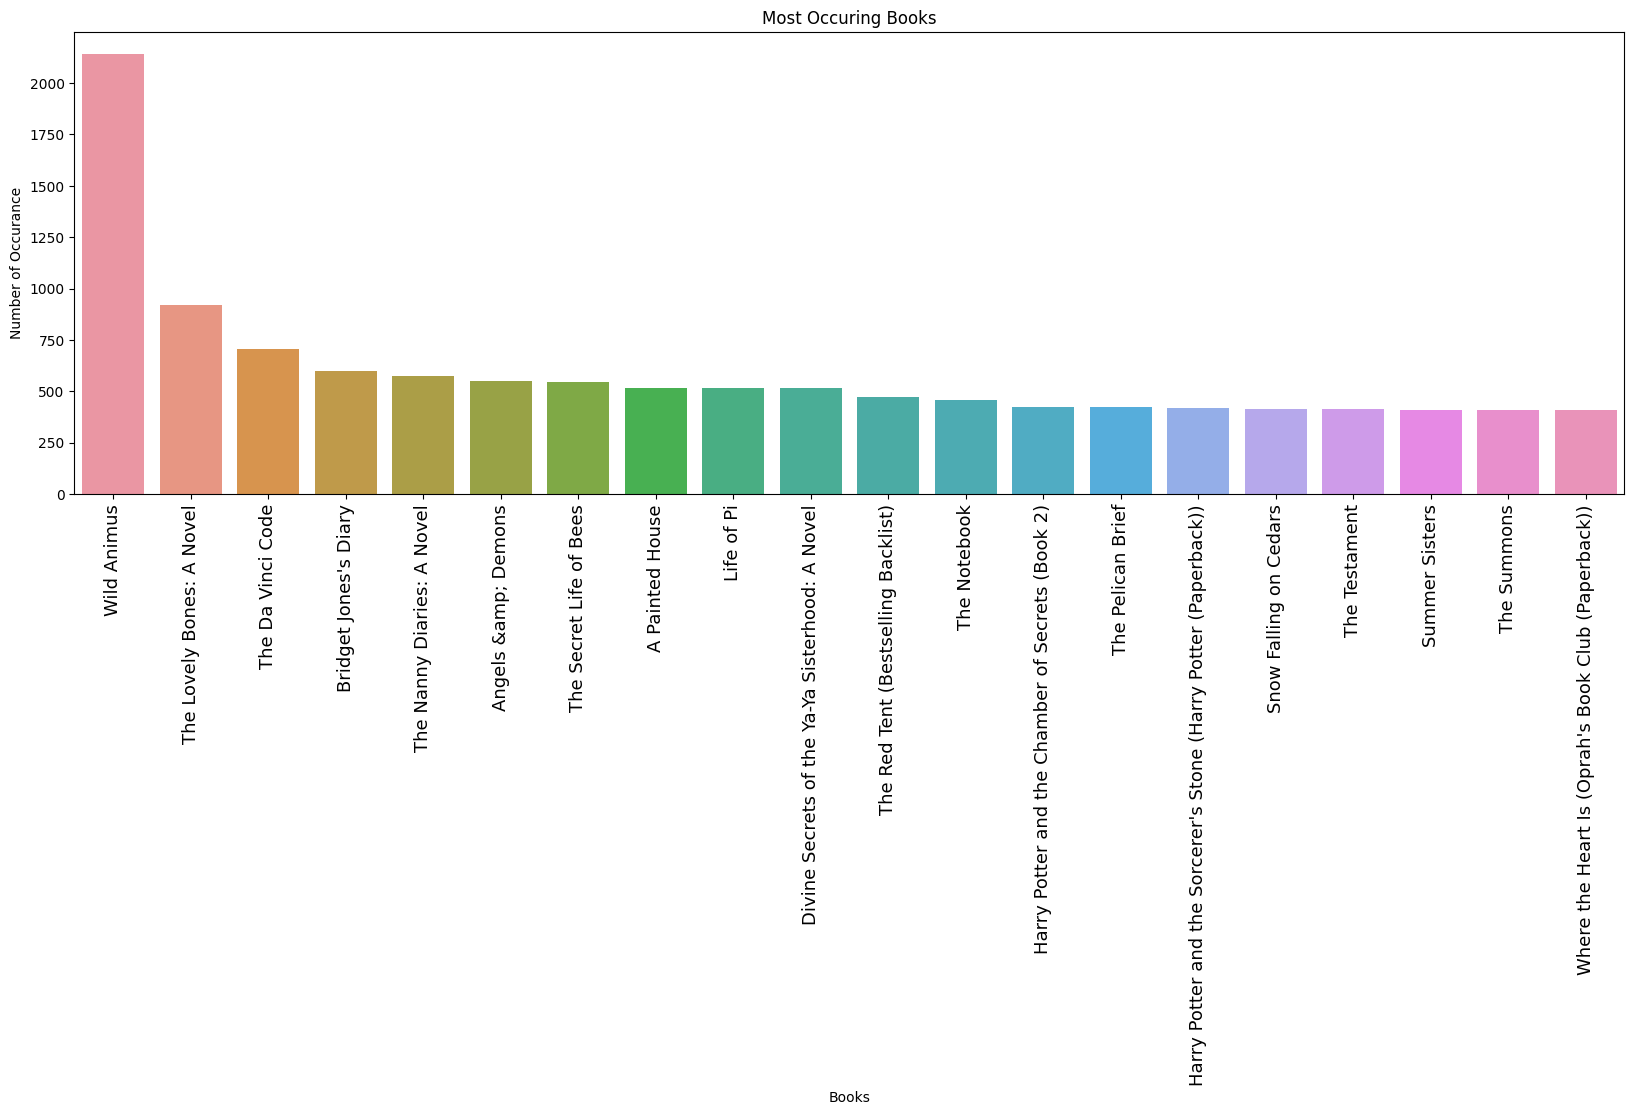

In [19]:
# to find most occuring book in our data
plt.figure(figsize=(20,6))
book=Data['Book-Title'].value_counts()[:20]
sns.barplot(x=book.index, y=book)
plt.title("Most Occuring Books")
plt.ylabel("Number of Occurance")
plt.xlabel("Books")
plt.xticks(rotation=90,fontsize=13)
plt.show()

Analysis:

The above graph gives us the most popular books (arranged in descending order) sold by the business.

For eaxmple, Wild Animus has sales of over 2500, the next most popular books The Lovely Bones: A Novel has sales over 1000, etc.

In [20]:
ratings.sort_values('No of times Rated',ascending=False)

Mean Ratings  \
Book-Title                                                         
Wild Animus                                             0.989257   
The Lovely Bones: A Novel                               4.238043   
The Da Vinci Code                                       4.529661   
Bridget Jones's Diary                                   3.400668   
The Nanny Diaries: A Novel                              3.225131   
...                                                          ...   
La Sagesse de la mer : Du cap colÃ?Â¨re au bout...      9.000000   
La Saison Des Loups                                     7.000000   
La Saison des cerisiers en fleur                        0.000000   
La Sale Guerre                                          0.000000   
Mile 4:  Mummies                                        5.000000   

                                                    No of times Rated  
Book-Title                                                             
Wild Animus                                                      2141  
The Lovely Bones: A Novel                                         920  
The Da Vinci Code                                                 708  
Bridget Jones's Diary                                             599  
The Nanny Diaries: A Novel                                        573  
...                                                               ...  
La Sagesse de la mer : Du cap colÃ?Â¨re au bout...                  1  
La Saison Des Loups                                                 1  
La Saison des cerisiers en fleur                                    1  
La Sale Guerre                                                      1  
Mile 4:  Mummies                                                    1  

[205170 rows x 2 columns]

In [21]:
top_most_frequent_rated_books = ratings[ratings['No of times Rated']>=50].sort_values('No of times Rated',ascending=False)
top_most_frequent_rated_books

Mean Ratings  \
Book-Title                                                         
Wild Animus                                             0.989257   
The Lovely Bones: A Novel                               4.238043   
The Da Vinci Code                                       4.529661   
Bridget Jones's Diary                                   3.400668   
The Nanny Diaries: A Novel                              3.225131   
...                                                          ...   
Palomino                                                2.240000   
Briar Rose                                              2.820000   
Hiroshima                                               4.320000   
Magic Kingdom for Sale - Sold! (Magic Kingdom o...      2.020000   
Microserfs                                              3.280000   

                                                    No of times Rated  
Book-Title                                                             
Wild Animus                                                      2141  
The Lovely Bones: A Novel                                         920  
The Da Vinci Code                                                 708  
Bridget Jones's Diary                                             599  
The Nanny Diaries: A Novel                                        573  
...                                                               ...  
Palomino                                                           50  
Briar Rose                                                         50  
Hiroshima                                                          50  
Magic Kingdom for Sale - Sold! (Magic Kingdom o...                 50  
Microserfs                                                         50  

[1573 rows x 2 columns]

In [22]:
top_most_frequent_rated_books = top_most_frequent_rated_books[top_most_frequent_rated_books['Mean Ratings']>=5]
top_most_frequent_rated_books

Mean Ratings  \
Book-Title                                                         
Harry Potter and the Chamber of Secrets (Book 2)        5.148235   
Harry Potter and the Prisoner of Azkaban (Book 3)       5.966967   
Harry Potter and the Goblet of Fire (Book 4)            5.976271   
Harry Potter and the Order of the Phoenix (Book 5)      5.709898   
The Fellowship of the Ring (The Lord of the Rin...      5.040293   
Harry Potter and the Sorcerer's Stone (Book 1)          6.032864   
Ender's Game (Ender Wiggins Saga (Paperback))           5.317919   
The Little Prince                                       5.673077   
Charlotte's Web (Trophy Newbery)                        5.043011   
The Perks of Being a Wallflower                         5.675000   
Go Ask Alice                                            5.090909   
The Godfather                                           5.250000   
Jitterbug Perfume                                       5.187500   
The Lord of the Rings (Movie Art Cover)                 5.645161   
The Hobbit                                              6.033333   
The Hobbit: or There and Back Again                     5.000000   
Griffin &amp; Sabine: An Extraordinary Correspo...      5.943396   
Free                                                    8.115385   

                                                    No of times Rated  
Book-Title                                                             
Harry Potter and the Chamber of Secrets (Book 2)                  425  
Harry Potter and the Prisoner of Azkaban (Book 3)                 333  
Harry Potter and the Goblet of Fire (Book 4)                      295  
Harry Potter and the Order of the Phoenix (Book 5)                293  
The Fellowship of the Ring (The Lord of the Rin...                273  
Harry Potter and the Sorcerer's Stone (Book 1)                    213  
Ender's Game (Ender Wiggins Saga (Paperback))                     173  
The Little Prince                                                 104  
Charlotte's Web (Trophy Newbery)                                   93  
The Perks of Being a Wallflower                                    80  
Go Ask Alice                                                       66  
The Godfather                                                      64  
Jitterbug Perfume                                                  64  
The Lord of the Rings (Movie Art Cover)                            62  
The Hobbit                                                         60  
The Hobbit: or There and Back Again                                59  
Griffin &amp; Sabine: An Extraordinary Correspo...                 53  
Free                                                               52

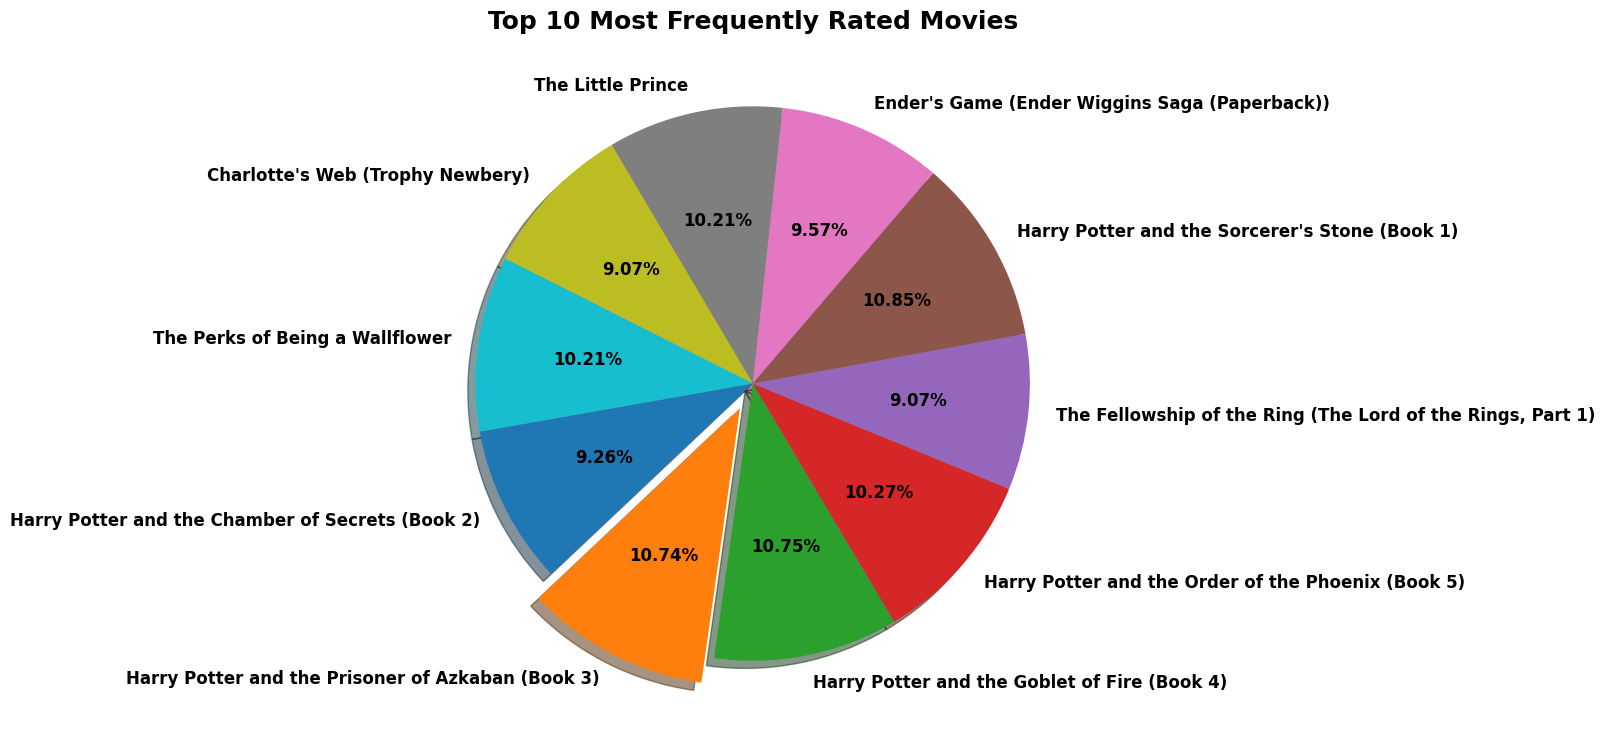

In [23]:
plt.figure(figsize = (16,9))
plt.pie(top_most_frequent_rated_books['Mean Ratings'].head(10),
       labels=top_most_frequent_rated_books['Mean Ratings'].head(10).index,
       explode = [0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
       autopct= '%.2f%%',
       shadow= True,
       startangle= 190,
       textprops = {'size':'large',
                   'fontweight':'bold',
                    'rotation':0,
                   'color':'black'})
#plt.legend(loc= 'best')
plt.title("Top 10 Most Frequently Rated Movies", fontsize = 18, fontweight = 'bold')
plt.show()

In [24]:
Data['Year']=Data['Year-Of-Publication'].astype('int')

In [25]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 753296 entries, 0 to 1031134
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 753296 non-null  object 
 1   Book-Title           753296 non-null  object 
 2   Book-Author          753296 non-null  object 
 3   Year-Of-Publication  753296 non-null  object 
 4   Publisher            753296 non-null  object 
 5   Image-URL-S          753296 non-null  object 
 6   Image-URL-M          753296 non-null  object 
 7   Image-URL-L          753296 non-null  object 
 8   User-ID              753296 non-null  int64  
 9   Book-Rating          753296 non-null  int64  
 10  Location             753296 non-null  object 
 11  Age                  753296 non-null  float64
 12  Year                 753296 non-null  int32  
dtypes: float64(1), int32(1), int64(2), object(9)
memory usage: 77.6+ MB


In [26]:
Data['Year'].max()  # to check in which year the last book was published

2050

In [27]:
Data[Data['Year']==2050][['Book-Title','Book-Author','Publisher','Book-Rating']] # to check which all books was published in the year 2050

Book-Title       Book-Author  \
128900  Alice's Adventures in Wonderland and Through t...     Lewis Carroll   
255425  Alice's Adventures in Wonderland and Through t...     Lewis Carroll   
439092  Alice's Adventures in Wonderland and Through t...     Lewis Carroll   
739056      Outline of European Architecture (Pelican S.)  Nikolaus Pevsner   
798513  Alice's Adventures in Wonderland and Through t...     Lewis Carroll   
816826  Alice's Adventures in Wonderland and Through t...     Lewis Carroll   

           Publisher  Book-Rating  
128900  Puffin Books            0  
255425  Puffin Books            7  
439092  Puffin Books            0  
739056   Penguin USA           10  
798513  Puffin Books           10  
816826  Puffin Books            7

In [28]:
Data.groupby(['Year'])['Book-Title'].agg('count').sort_values(ascending=False).head(20) # to check how many books got published in a particular year

Year
2002    65904
2001    57356
2003    57223
1999    54014
2000    52025
1998    46016
1997    42708
1996    42430
1995    39117
1994    33547
1993    27684
1992    25375
1991    23660
1990    22185
2004    21432
1989    18340
1988    15270
1987    13761
1986    12429
0       10442
Name: Book-Title, dtype: int64

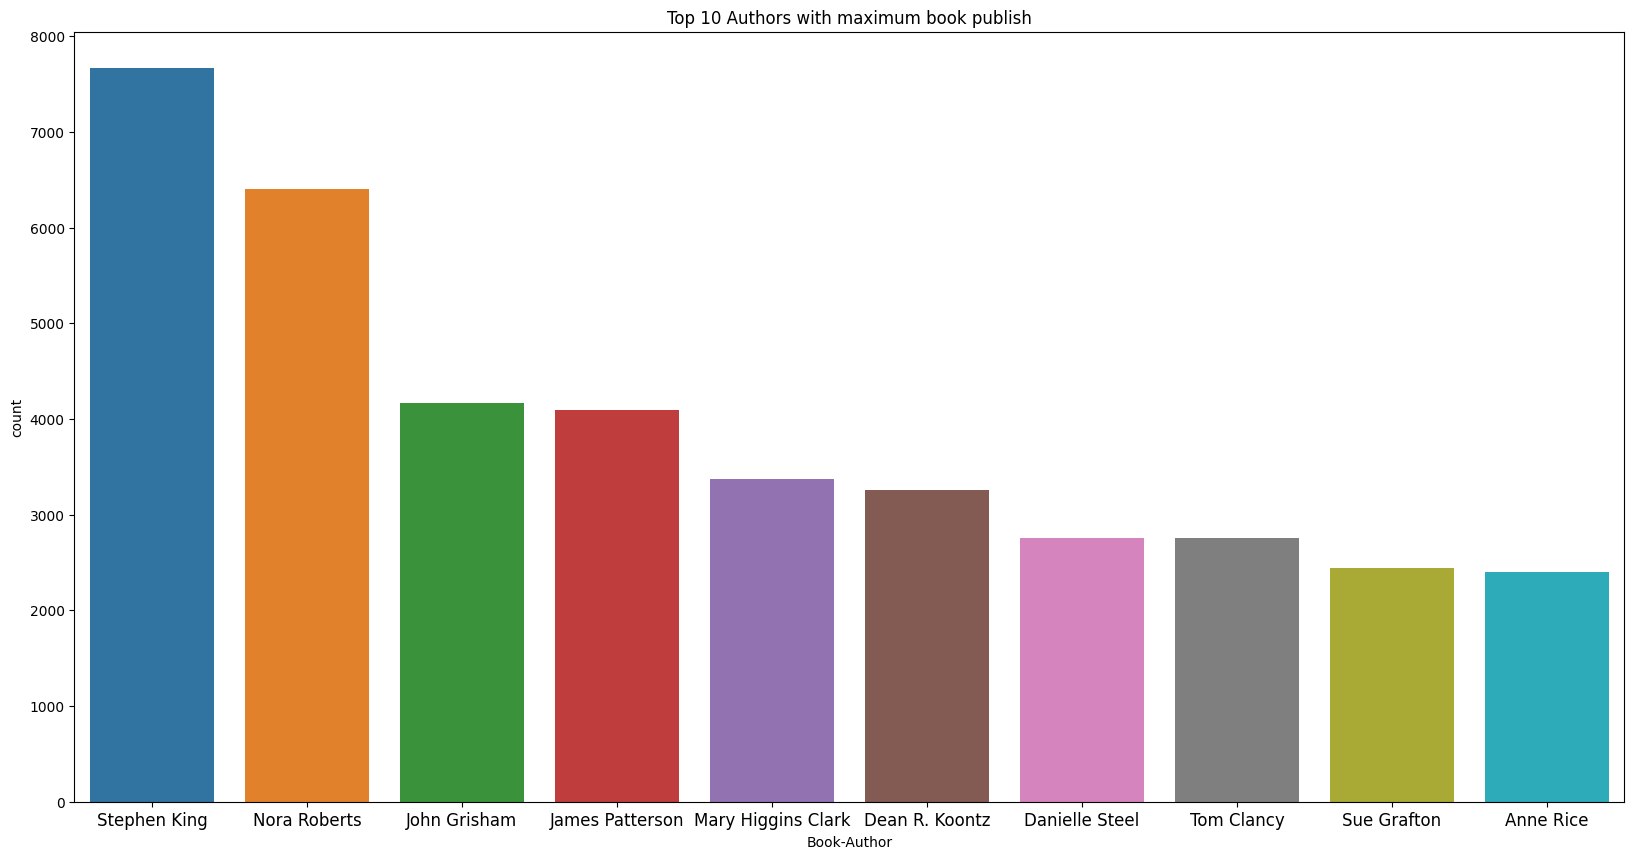

In [29]:
plt.figure(figsize=(20,10))
sns.countplot(x='Book-Author', data=Data, order=Data['Book-Author'].value_counts().iloc[:10].index)
plt.title("Top 10 Authors with maximum book publish")
plt.xticks(fontsize=12)
plt.show()

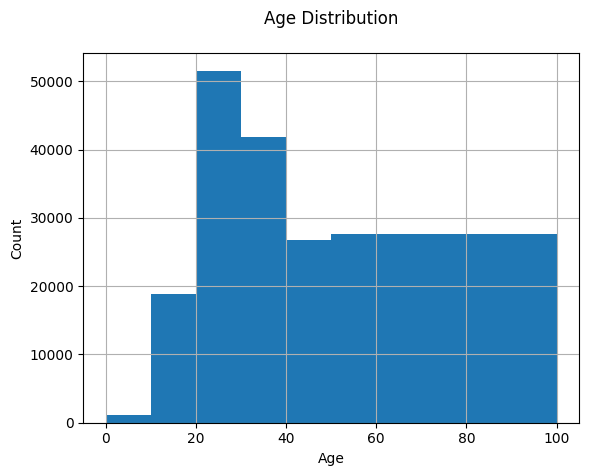

In [30]:
# to find age distribution in our data
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('system2.png', bbox_inches='tight')
plt.show()

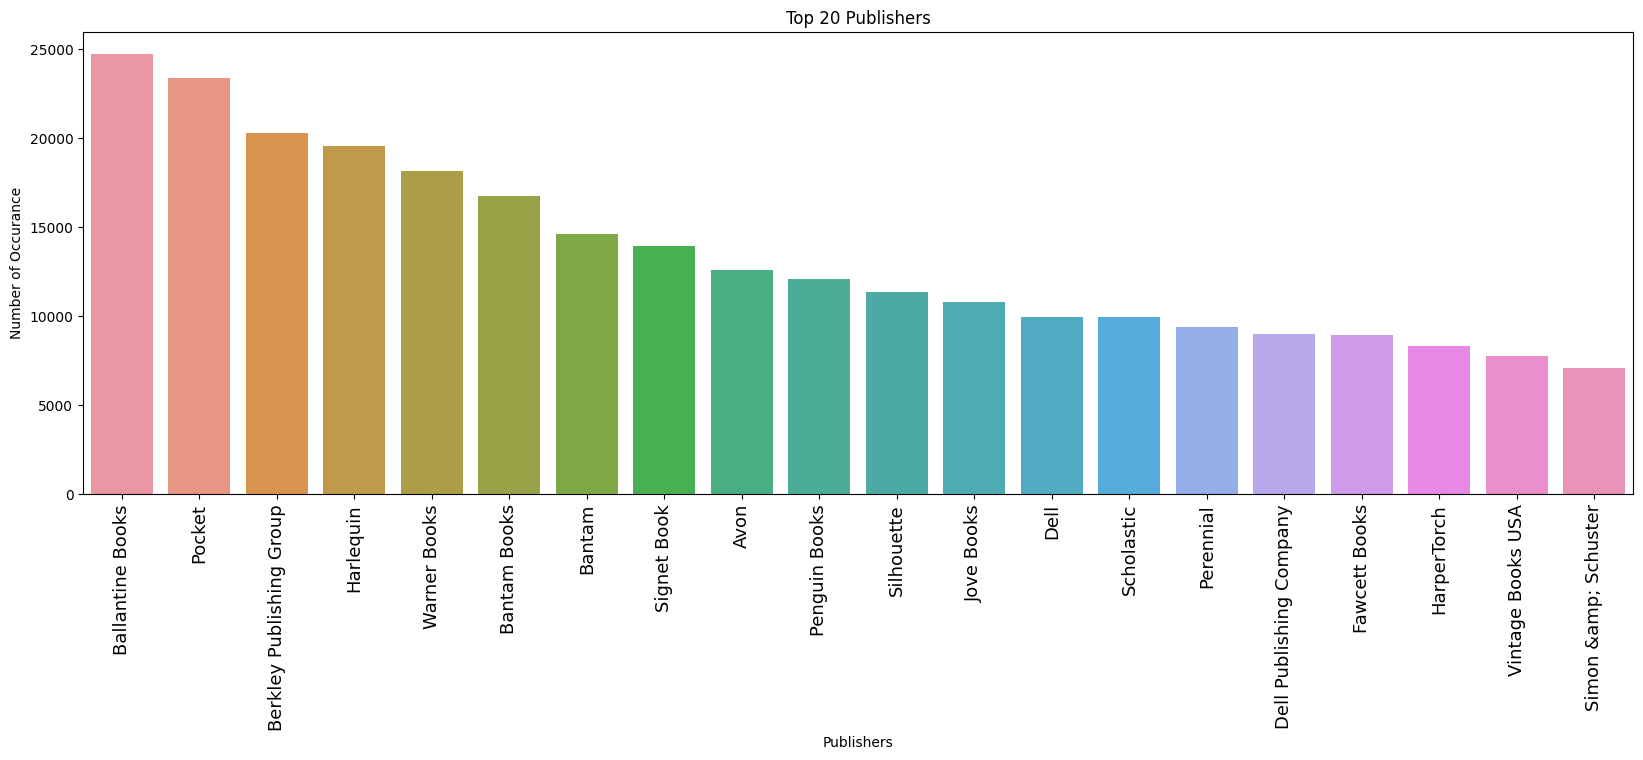

In [31]:
# to find top publishers in our data
plt.figure(figsize=(20,6))
publisher=Data['Publisher'].value_counts()[:20]
sns.barplot(x=publisher.index, y=publisher)
plt.title("Top 20 Publishers")
plt.ylabel("Number of Occurance")
plt.xlabel("Publishers")
plt.xticks(rotation=90,fontsize=13)
plt.show()

In [32]:
##pip install pandas-profiling

In [33]:
##from pandas_profiling import ProfileReport

In [34]:
##from pandas_profiling import ProfileReport
##profile = ProfileReport(pd.read_csv('Data.csv'), explorative=True)
##profile.to_file("pandas.html")

In [35]:
##pip install autoviz

In [36]:
##from autoviz.AutoViz_Class import AutoViz_Class
##autoviz = AutoViz_Class().AutoViz('Data.csv')

## Recommendation System - Part I
### Product popularity based recommendation system targeted at new customers
* Popularity based are a great strategy to target the new customers with the most popular products sold on a business's website and is very useful to cold start a recommendation engine..

### Popularity Based Recommender System

In [37]:
Data['Book-Title'].value_counts().reset_index()

index  Book-Title
0                                             Wild Animus        2141
1                               The Lovely Bones: A Novel         920
2                                       The Da Vinci Code         708
3                                   Bridget Jones's Diary         599
4                              The Nanny Diaries: A Novel         573
...                                                   ...         ...
205165                           Caribische winter: Roman           1
205166                     The Island of Day Before - Ome           1
205167                       The Case of the Waylaid Wolf           1
205168  The Rough Guide to Personal Computers (Rough G...           1
205169                   Anglo-American Cataloguing Rules           1

[205170 rows x 2 columns]

In [38]:
ratings = pd.DataFrame(Data.groupby('Book-Title')['Book-Rating'].mean())
ratings.rename({'Book-Rating':'avg_ratings'}, axis=1 , inplace =True)
ratings['num_ratings'] = pd.DataFrame(Data.groupby('Book-Title')['Book-Rating'].count())
ratings.reset_index(inplace=True)
ratings

Book-Title  avg_ratings  \
0        A Light in the Storm: The Civil War Diary of ...     0.000000   
1                                   Always Have Popsicles     0.000000   
2                    Apple Magic (The Collector's series)     0.000000   
3        Ask Lily (Young Women of Faith: Lily Series, ...     8.000000   
4                                            Dark Justice    10.000000   
...                                                   ...          ...   
205165                                      Ã?Â?lpiraten.     0.000000   
205166                     Ã?Â?rger mit Produkt X. Roman.     5.250000   
205167                                Ã?Â?sterlich leben.     7.000000   
205168                              Ã?Â?stlich der Berge.     2.666667   
205169                                  Ã?Â?thique en toc     4.000000   

        num_ratings  
0                 1  
1                 1  
2                 1  
3                 1  
4                 1  
...             ...  
205165            1  
205166            4  
205167            1  
205168            3  
205169            2  

[205170 rows x 3 columns]

In [39]:
popular_books = ratings[ratings['num_ratings']>=250].sort_values('avg_ratings', ascending=False).head(50)
popular_books.reset_index(inplace=True, drop=True)
popular_books

Book-Title  avg_ratings  \
0        Harry Potter and the Goblet of Fire (Book 4)     5.976271   
1   Harry Potter and the Prisoner of Azkaban (Book 3)     5.966967   
2   Harry Potter and the Order of the Phoenix (Boo...     5.709898   
3    Harry Potter and the Chamber of Secrets (Book 2)     5.148235   
4   The Fellowship of the Ring (The Lord of the Ri...     5.040293   
5   Harry Potter and the Sorcerer's Stone (Harry P...     4.830144   
6                               To Kill a Mockingbird     4.810298   
7                  The Five People You Meet in Heaven     4.615599   
8                                   The Da Vinci Code     4.529661   
9                              The Catcher in the Rye     4.523220   
10                            The Secret Life of Bees     4.338208   
11                          The Lovely Bones: A Novel     4.238043   
12  Tuesdays with Morrie: An Old Man, a Young Man,...     4.208092   
13                                     Fahrenheit 451     4.047138   
14                          Girl with a Pearl Earring     4.045181   
15    The Golden Compass (His Dark Materials, Book 1)     3.988048   
16                The Red Tent (Bestselling Backlist)     3.970339   
17  Where the Heart Is (Oprah's Book Club (Paperba...     3.953431   
18                                         Life of Pi     3.945736   
19                                        Good in Bed     3.925501   
20                                     The Bean Trees     3.867704   
21                                Angels &amp; Demons     3.777174   
22                                         Red Dragon     3.707143   
23              She's Come Undone (Oprah's Book Club)     3.694118   
24                       Suzanne's Diary for Nicholas     3.626543   
25                             Me Talk Pretty One Day     3.608563   
26                         Interview with the Vampire     3.567164   
27  Confessions of a Shopaholic (Summer Display Op...     3.561265   
28                                1st to Die: A Novel     3.560241   
29                            A Prayer for Owen Meany     3.429603   
30                                        The Summons     3.403423   
31                              Bridget Jones's Diary     3.400668   
32  She's Come Undone (Oprah's Book Club (Paperback))     3.398792   
33                                           Timeline     3.397260   
34                         The Pilot's Wife : A Novel     3.393048   
35                                           Chocolat     3.387833   
36                                    The Beach House     3.365132   
37  The No. 1 Ladies' Detective Agency (Today Show...     3.316129   
38                      The Poisonwood Bible: A Novel     3.311526   
39  The Divine Secrets of the Ya-Ya Sisterhood: A ...     3.304833   
40                           White Oleander : A Novel     3.304833   
41                                       The Notebook     3.293860   
42                                      Jurassic Park     3.289817   
43                                 A Walk to Remember     3.239700   
44                                     Summer Sisters     3.228710   
45                         The Nanny Diaries: A Novel     3.225131   
46                  Little Altars Everywhere: A Novel     3.222581   
47    Divine Secrets of the Ya-Ya Sisterhood: A Novel     3.161479   
48                                        The Partner     3.093168   
49                                     A Time to Kill     3.065990   

    num_ratings  
0           295  
1           333  
2           293  
3           425  
4           273  
5           418  
6           369  
7           359  
8           708  
9           323  
10          547  
11          920  
12          346  
13          297  
14          332  
15          251  
16          472  
17          408  
18          516  
19          349  
20          257  
21          552  
22          280  
23          340  
24          324  
25  

In [40]:
popular_books.sort_values('num_ratings', ascending=False).head(50)

Book-Title  avg_ratings  \
11                          The Lovely Bones: A Novel     4.238043   
8                                   The Da Vinci Code     4.529661   
31                              Bridget Jones's Diary     3.400668   
45                         The Nanny Diaries: A Novel     3.225131   
21                                Angels &amp; Demons     3.777174   
10                            The Secret Life of Bees     4.338208   
18                                         Life of Pi     3.945736   
47    Divine Secrets of the Ya-Ya Sisterhood: A Novel     3.161479   
16                The Red Tent (Bestselling Backlist)     3.970339   
41                                       The Notebook     3.293860   
3    Harry Potter and the Chamber of Secrets (Book 2)     5.148235   
5   Harry Potter and the Sorcerer's Stone (Harry P...     4.830144   
44                                     Summer Sisters     3.228710   
30                                        The Summons     3.403423   
17  Where the Heart Is (Oprah's Book Club (Paperba...     3.953431   
26                         Interview with the Vampire     3.567164   
49                                     A Time to Kill     3.065990   
42                                      Jurassic Park     3.289817   
34                         The Pilot's Wife : A Novel     3.393048   
6                               To Kill a Mockingbird     4.810298   
33                                           Timeline     3.397260   
7                  The Five People You Meet in Heaven     4.615599   
19                                        Good in Bed     3.925501   
12  Tuesdays with Morrie: An Old Man, a Young Man,...     4.208092   
23              She's Come Undone (Oprah's Book Club)     3.694118   
1   Harry Potter and the Prisoner of Azkaban (Book 3)     5.966967   
14                          Girl with a Pearl Earring     4.045181   
28                                1st to Die: A Novel     3.560241   
32  She's Come Undone (Oprah's Book Club (Paperback))     3.398792   
25                             Me Talk Pretty One Day     3.608563   
24                       Suzanne's Diary for Nicholas     3.626543   
9                              The Catcher in the Rye     4.523220   
48                                        The Partner     3.093168   
38                      The Poisonwood Bible: A Novel     3.311526   
37  The No. 1 Ladies' Detective Agency (Today Show...     3.316129   
46                  Little Altars Everywhere: A Novel     3.222581   
36                                    The Beach House     3.365132   
13                                     Fahrenheit 451     4.047138   
0        Harry Potter and the Goblet of Fire (Book 4)     5.976271   
2   Harry Potter and the Order of the Phoenix (Boo...     5.709898   
22                                         Red Dragon     3.707143   
29                            A Prayer for Owen Meany     3.429603   
4   The Fellowship of the Ring (The Lord of the Ri...     5.040293   
39  The Divine Secrets of the Ya-Ya Sisterhood: A ...     3.304833   
40                           White Oleander : A Novel     3.304833   
43                                 A Walk to Remember     3.239700   
35                                           Chocolat     3.387833   
20                                     The Bean Trees     3.867704   
27  Confessions of a Shopaholic (Summer Display Op...     3.561265   
15    The Golden Compass (His Dark Materials, Book 1)     3.988048   

    num_ratings  
11          920  
8           708  
31          599  
45          573  
21          552  
10          547  
18          516  
47          514  
16          472  
41          456  
3           425  
5           418  
44          411  
30          409  
17          408  
26          402  
49          394  
42          383  
34          374  
6           369  
33          365  
7           359  
19          349  
12          346  
23          340  
1   

In [41]:
fifty_popular_books = popular_books.merge(books, on='Book-Title').drop_duplicates('Book-Title').reset_index(drop=True)
fifty_popular_books = fifty_popular_books[['Book-Title','avg_ratings','num_ratings','Book-Author','Publisher','Image-URL-M']]
fifty_popular_books.head(5)

Book-Title  avg_ratings  \
0       Harry Potter and the Goblet of Fire (Book 4)     5.976271   
1  Harry Potter and the Prisoner of Azkaban (Book 3)     5.966967   
2  Harry Potter and the Order of the Phoenix (Boo...     5.709898   
3   Harry Potter and the Chamber of Secrets (Book 2)     5.148235   
4  The Fellowship of the Ring (The Lord of the Ri...     5.040293   

   num_ratings     Book-Author   Publisher  \
0          295   J. K. Rowling  Scholastic   
1          333   J. K. Rowling  Scholastic   
2          293   J. K. Rowling  Scholastic   
3          425   J. K. Rowling  Scholastic   
4          273  J.R.R. TOLKIEN     Del Rey   

                                         Image-URL-M  
0  http://images.amazon.com/images/P/0439139597.0...  
1  http://images.amazon.com/images/P/0439136350.0...  
2  http://images.amazon.com/images/P/043935806X.0...  
3  http://images.amazon.com/images/P/0439064872.0...  
4  http://images.amazon.com/images/P/0345339703.0...

In [42]:
fifty_popular_books['Image-URL-M'][39]

'http://images.amazon.com/images/P/0060502258.01.MZZZZZZZ.jpg'

In [43]:
fifty_popular_books['Image-URL-M'][0][:48]

'http://images.amazon.com/images/P/0439139597.01.'

In [44]:
fifty_popular_books['Image-URL-M'][0][:48] +'L'+ fifty_popular_books['Image-URL-M'][0][49:]

'http://images.amazon.com/images/P/0439139597.01.LZZZZZZZ.jpg'

In [45]:
import pickle
pickle.dump(fifty_popular_books, open('popular.pkl','wb'))

In [46]:
fifty_popular_books.to_csv('fifty_popular_books.csv', index=False)
pd.read_csv('fifty_popular_books.csv')

Book-Title  avg_ratings  \
0        Harry Potter and the Goblet of Fire (Book 4)     5.976271   
1   Harry Potter and the Prisoner of Azkaban (Book 3)     5.966967   
2   Harry Potter and the Order of the Phoenix (Boo...     5.709898   
3    Harry Potter and the Chamber of Secrets (Book 2)     5.148235   
4   The Fellowship of the Ring (The Lord of the Ri...     5.040293   
5   Harry Potter and the Sorcerer's Stone (Harry P...     4.830144   
6                               To Kill a Mockingbird     4.810298   
7                  The Five People You Meet in Heaven     4.615599   
8                                   The Da Vinci Code     4.529661   
9                              The Catcher in the Rye     4.523220   
10                            The Secret Life of Bees     4.338208   
11                          The Lovely Bones: A Novel     4.238043   
12  Tuesdays with Morrie: An Old Man, a Young Man,...     4.208092   
13                                     Fahrenheit 451     4.047138   
14                          Girl with a Pearl Earring     4.045181   
15    The Golden Compass (His Dark Materials, Book 1)     3.988048   
16                The Red Tent (Bestselling Backlist)     3.970339   
17  Where the Heart Is (Oprah's Book Club (Paperba...     3.953431   
18                                         Life of Pi     3.945736   
19                                        Good in Bed     3.925501   
20                                     The Bean Trees     3.867704   
21                                Angels &amp; Demons     3.777174   
22                                         Red Dragon     3.707143   
23              She's Come Undone (Oprah's Book Club)     3.694118   
24                       Suzanne's Diary for Nicholas     3.626543   
25                             Me Talk Pretty One Day     3.608563   
26                         Interview with the Vampire     3.567164   
27  Confessions of a Shopaholic (Summer Display Op...     3.561265   
28                                1st to Die: A Novel     3.560241   
29                            A Prayer for Owen Meany     3.429603   
30                                        The Summons     3.403423   
31                              Bridget Jones's Diary     3.400668   
32  She's Come Undone (Oprah's Book Club (Paperback))     3.398792   
33                                           Timeline     3.397260   
34                         The Pilot's Wife : A Novel     3.393048   
35                                           Chocolat     3.387833   
36                                    The Beach House     3.365132   
37  The No. 1 Ladies' Detective Agency (Today Show...     3.316129   
38                      The Poisonwood Bible: A Novel     3.311526   
39  The Divine Secrets of the Ya-Ya Sisterhood: A ...     3.304833   
40                           White Oleander : A Novel     3.304833   
41                                       The Notebook     3.293860   
42                                      Jurassic Park     3.289817   
43                                 A Walk to Remember     3.239700   
44                                     Summer Sisters     3.228710   
45                         The Nanny Diaries: A Novel     3.225131   
46                  Little Altars Everywhere: A Novel     3.222581   
47    Divine Secrets of the Ya-Ya Sisterhood: A Novel     3.161479   
48                                        The Partner     3.093168   
49                                     A Time to Kill     3.065990   

    num_ratings             Book-Author                      Publisher  \
0           295           J. K. Rowling                     Scholastic   
1           333           J. K. Rowling                     Scholastic   
2           293           J. K. Rowling                     Scholastic   
3           425           J. K. Rowling                     Scholastic   
4           273          J.R.R. TOLKIEN                        Del Rey   
5           418           J.

In [47]:
twenty_popular_books = fifty_popular_books.head(20)
twenty_popular_books

Book-Title  avg_ratings  \
0        Harry Potter and the Goblet of Fire (Book 4)     5.976271   
1   Harry Potter and the Prisoner of Azkaban (Book 3)     5.966967   
2   Harry Potter and the Order of the Phoenix (Boo...     5.709898   
3    Harry Potter and the Chamber of Secrets (Book 2)     5.148235   
4   The Fellowship of the Ring (The Lord of the Ri...     5.040293   
5   Harry Potter and the Sorcerer's Stone (Harry P...     4.830144   
6                               To Kill a Mockingbird     4.810298   
7                  The Five People You Meet in Heaven     4.615599   
8                                   The Da Vinci Code     4.529661   
9                              The Catcher in the Rye     4.523220   
10                            The Secret Life of Bees     4.338208   
11                          The Lovely Bones: A Novel     4.238043   
12  Tuesdays with Morrie: An Old Man, a Young Man,...     4.208092   
13                                     Fahrenheit 451     4.047138   
14                          Girl with a Pearl Earring     4.045181   
15    The Golden Compass (His Dark Materials, Book 1)     3.988048   
16                The Red Tent (Bestselling Backlist)     3.970339   
17  Where the Heart Is (Oprah's Book Club (Paperba...     3.953431   
18                                         Life of Pi     3.945736   
19                                        Good in Bed     3.925501   

    num_ratings      Book-Author                      Publisher  \
0           295    J. K. Rowling                     Scholastic   
1           333    J. K. Rowling                     Scholastic   
2           293    J. K. Rowling                     Scholastic   
3           425    J. K. Rowling                     Scholastic   
4           273   J.R.R. TOLKIEN                        Del Rey   
5           418    J. K. Rowling         Arthur A. Levine Books   
6           369       Harper Lee     Little Brown &amp; Company   
7           359      Mitch Albom                       Hyperion   
8           708        Dan Brown                      Doubleday   
9           323    J.D. Salinger                  Little, Brown   
10          547    Sue Monk Kidd                  Penguin Books   
11          920     Alice Sebold                  Little, Brown   
12          346      MITCH ALBOM                      Doubleday   
13          297     Ray Bradbury                Distribooks Inc   
14          332  Tracy Chevalier                    Plume Books   
15          251   PHILIP PULLMAN  Knopf Books for Young Readers   
16          472    Anita Diamant                    Picador USA   
17          408     Billie Letts                   Warner Books   
18          516      Yann Martel                       Harcourt   
19          349  Jennifer Weiner        Washington Square Press   

                                          Image-URL-M  
0   http://images.amazon.com/images/P/0439139597.0...  
1   http://images.amazon.com/images/P/0439136350.0...  
2   http://images.amazon.com/images/P/043935806X.0...  
3   http://images.amazon.com/images/P/0439064872.0...  
4   http://images.amazon.com/images/P/0345339703.0...  
5   http://images.amazon.com/images/P/059035342X.0...  
6   http://images.amazon.com/images/P/0446310786.0...  
7   http://images.amazon.com/images/P/0786868716.0...  
8   http://images.amazon.com/images/P/0385504209.0...  
9   http://images.amazon.com/images/P/0316769487.0...  
10  http://images.amazon.com/images/P/0142001740.0...  
11  http://images.amazon.com/images/P/0316666343.0...  
12  http://images.amazon.com/images/P/0385484518.0...  
13  http://images.amazon.com/images/P/3257208626.0...  
14  http://images.amazon.com/images/P/0452282152.0...  
15  http://images.amazon.com/images/P/037582345X.0...  
16  http://images.amazon.com/images/P/0312195516.0...  
17  http://images.amazon.com/images/P/0446672211.0...  
18  http://images.amazon.com/images/P/0151008116.0...  
19  http://images.amazon.com/images/P/074341

In [48]:
!pip install Pillow


In [49]:
from PIL import Image


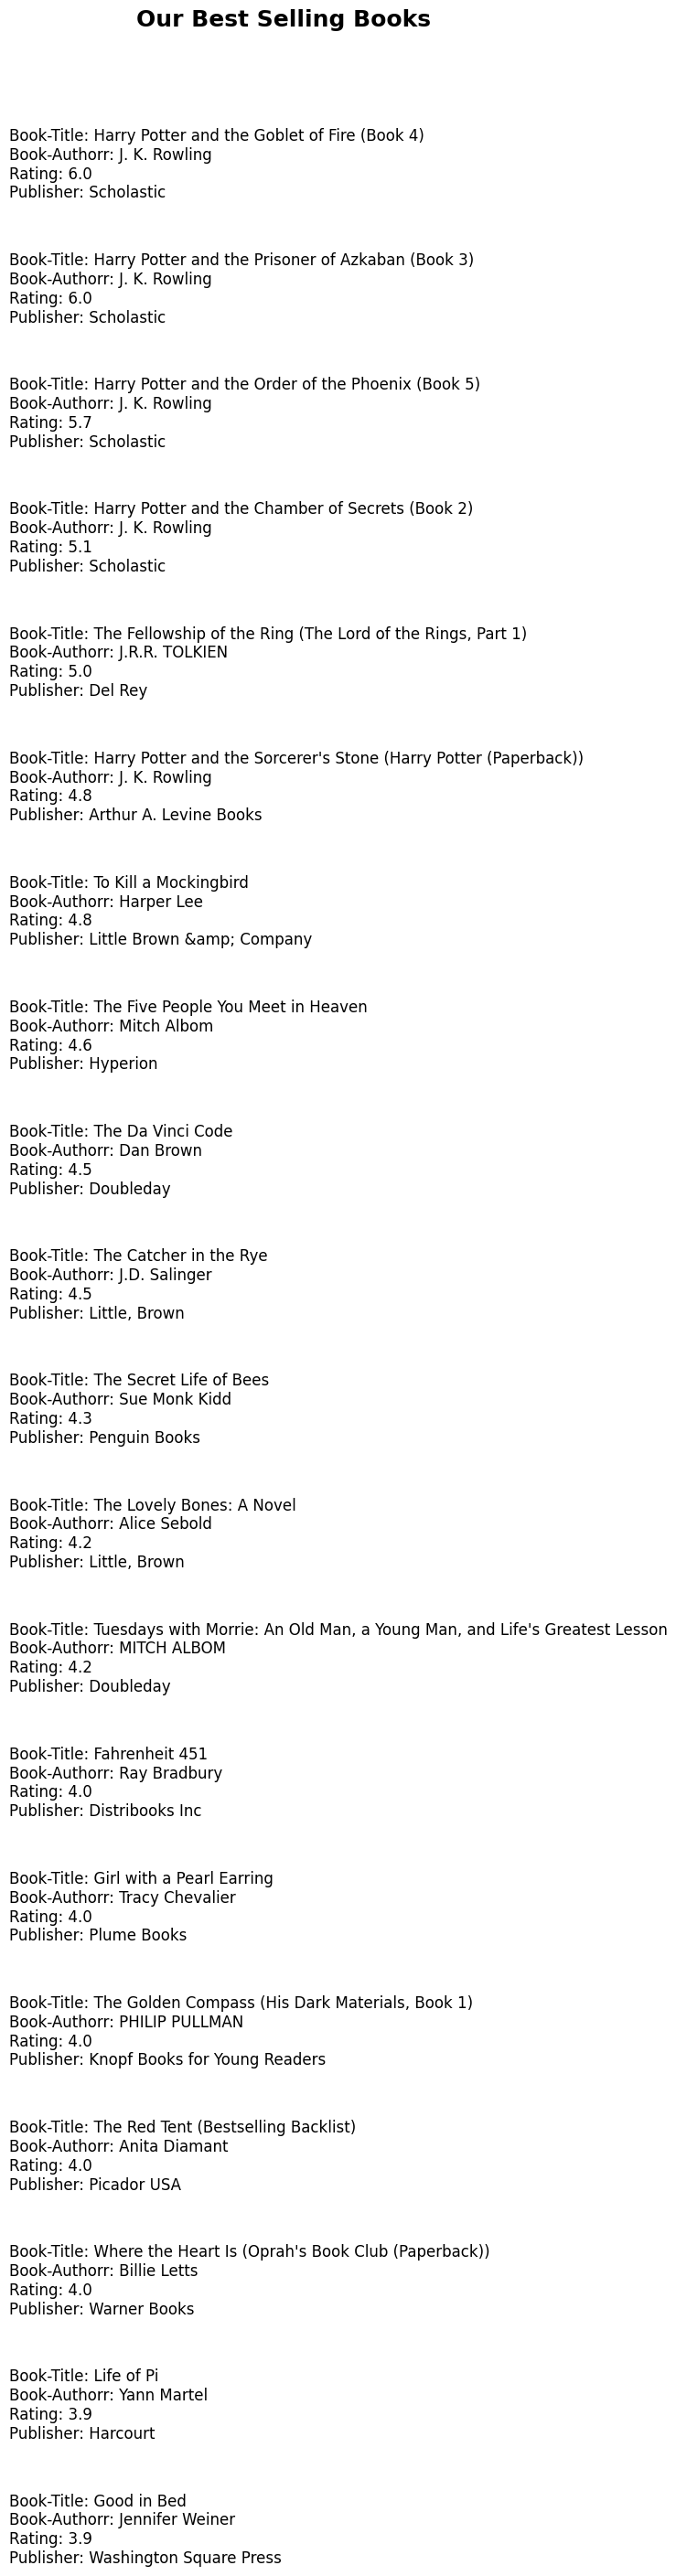

In [50]:
fig, axs = plt.subplots(ncols=1, nrows=20, figsize=(8, 30))
fig.suptitle('Our Best Selling Books', size=18, fontweight='bold')

for i in range(len(twenty_popular_books)):
    axs[i].axis("off")
    axs[i].set_title('Book-Title: {}\nBook-Authorr: {}\nRating: {}\nPublisher: {}'.format(
        twenty_popular_books['Book-Title'][i],
        twenty_popular_books['Book-Author'][i],
        round(twenty_popular_books['avg_ratings'][i], 1),
        twenty_popular_books['Publisher'][i]),
        y=-0.1, color="black", fontsize=12, loc='left')

plt.subplots_adjust(top=0.95, bottom=0.05)  

plt.show()



# Pre-Processings

# Data Cleaning
Removing Users who have rated less than 50 Books

In [51]:
user_counts = pd.DataFrame(Data.groupby('User-ID').count()['Book-Rating']).rename({'Book-Rating':'no_times_rated'}, axis=1).reset_index()
user_counts

User-ID  no_times_rated
0            2               1
1           10               1
2           19               1
3           20               1
4           36               1
...        ...             ...
53882   278844               2
53883   278846               1
53884   278849               4
53885   278851              23
53886   278852               1

[53887 rows x 2 columns]

In [52]:
Data.head(3)

ISBN                          Book-Title           Book-Author  \
0   0195153448                 Classical Mythology    Mark P. O. Morford   
18  0002005018                        Clara Callan  Richard Bruce Wright   
19  0786868716  The Five People You Meet in Heaven           Mitch Albom   

   Year-Of-Publication                Publisher  \
0                 2002  Oxford University Press   
18                2001    HarperFlamingo Canada   
19                2003                 Hyperion   

                                          Image-URL-S  \
0   http://images.amazon.com/images/P/0195153448.0...   
18  http://images.amazon.com/images/P/0002005018.0...   
19  http://images.amazon.com/images/P/0786868716.0...   

                                          Image-URL-M  \
0   http://images.amazon.com/images/P/0195153448.0...   
18  http://images.amazon.com/images/P/0002005018.0...   
19  http://images.amazon.com/images/P/0786868716.0...   

                                          Image-URL-L  User-ID  Book-Rating  \
0   http://images.amazon.com/images/P/0195153448.0...        2            0   
18  http://images.amazon.com/images/P/0002005018.0...    11400            0   
19  http://images.amazon.com/images/P/0786868716.0...    11400            9   

                     Location   Age  Year  
0   stockton, california, usa  18.0  2002  
18    ottawa, ontario, canada  49.0  2001  
19    ottawa, ontario, canada  49.0  2003

In [53]:
final_books = pd.merge(Data, user_counts, on='User-ID')
final_books.drop(columns = ['Location','ISBN',
                   'Image-URL-S','Image-URL-L','Age',
                   'Year'],axis=1,inplace = True) #remove useless cols
final_books.head()

Book-Title           Book-Author  \
0                    Classical Mythology    Mark P. O. Morford   
1                           Clara Callan  Richard Bruce Wright   
2     The Five People You Meet in Heaven           Mitch Albom   
3                             Life of Pi           Yann Martel   
4  She's Come Undone (Oprah's Book Club)            Wally Lamb   

  Year-Of-Publication                Publisher  \
0                2002  Oxford University Press   
1                2001    HarperFlamingo Canada   
2                2003                 Hyperion   
3                2002                 Harcourt   
4                1998                   Pocket   

                                         Image-URL-M  User-ID  Book-Rating  \
0  http://images.amazon.com/images/P/0195153448.0...        2            0   
1  http://images.amazon.com/images/P/0002005018.0...    11400            0   
2  http://images.amazon.com/images/P/0786868716.0...    11400            9   
3  http://images.amazon.com/images/P/0151008116.0...    11400            6   
4  http://images.amazon.com/images/P/0671021001.0...    11400            0   

   no_times_rated  
0               1  
1              62  
2              62  
3              62  
4              62

In [54]:
final_books['User-ID'].nunique()

53887

In [55]:
final_books = final_books[final_books['no_times_rated']>=50].reset_index(drop=True)
final_books

Book-Title           Book-Author  \
0                                         Clara Callan  Richard Bruce Wright   
1                   The Five People You Meet in Heaven           Mitch Albom   
2                                           Life of Pi           Yann Martel   
3                She's Come Undone (Oprah's Book Club)            Wally Lamb   
4                  The Red Tent (Bestselling Backlist)         Anita Diamant   
...                                                ...                   ...   
530166  The Starry Wisdom : A Tribute to H P Lovecraft       H. P. Lovecraft   
530167                              The American Cause          Russell Kirk   
530168      The Conservative Mind: From Burke to Eliot          Russell Kirk   
530169                   The Equinox Volume 3 Number 1      Aleister Crowley   
530170            The Equinox: 10 Volume Set (Equinox)      Aleister Crowley   

       Year-Of-Publication              Publisher  \
0                     2001  HarperFlamingo Canada   
1                     2003               Hyperion   
2                     2002               Harcourt   
3                     1998                 Pocket   
4                     1998            Picador USA   
...                    ...                    ...   
530166                1995         Creation Books   
530167                2003              ISI Books   
530168                2001     Regnery Publishing   
530169                1992           Weiser Books   
530170                1972           Weiser Books   

                                              Image-URL-M  User-ID  \
0       http://images.amazon.com/images/P/0002005018.0...    11400   
1       http://images.amazon.com/images/P/0786868716.0...    11400   
2       http://images.amazon.com/images/P/0151008116.0...    11400   
3       http://images.amazon.com/images/P/0671021001.0...    11400   
4       http://images.amazon.com/images/P/0312195516.0...    11400   
...                                                   ...      ...   
530166  http://images.amazon.com/images/P/1871592321.0...    39527   
530167  http://images.amazon.com/images/P/1882926935.0...    39527   
530168  http://images.amazon.com/images/P/0895261715.0...    39527   
530169  http://images.amazon.com/images/P/0877282102.0...    39527   
530170  http://images.amazon.com/images/P/0877282064.0...    39527   

        Book-Rating  no_times_rated  
0                 0              62  
1                 9              62  
2                 6              62  
3                 0              62  
4                 7              62  
...             ...             ...  
530166            7              54  
530167            9              54  
530168            9              54  
530169            7              54  
530170            7              54  

[530171 rows x 8 columns]

In [56]:
final_books['User-ID'].nunique()

2370

In [57]:
final_books.sort_values('no_times_rated', ascending=False)

Book-Title  \
73830   Mary-Kate &amp; Ashley Switching Goals (Mary-K...   
78128                                   Ed Emberley's ABC   
78138   Walt Disney's If You Meet Snow White (Golden L...   
78137                        Toy Story 2 (Look-Look Book)   
78136     The Lion Who Couldn't Say No (Beginning Reader)   
...                                                   ...   
407883                             Notes for Another Life   
407884                              Concise Light on Yoga   
407885                              Natural Pregnancy A-Z   
488707                              El Palacio de La Luna   
411292       White Oleander : A Novel (Oprah's Book Club)   

                         Book-Author Year-Of-Publication            Publisher  \
73830   Mary-Kate &amp; Ashley Olsen                2000  HarperEntertainment   
78128                    Ed Emberley                1982        Smithmark Pub   
78138                  Margo Lundell                1996         Golden Books   
78137                  Diane Muldrow                1999         Golden Books   
78136                     Ken Wagner                1991         Golden Books   
...                              ...                 ...                  ...   
407883            Sue Ellen Bridgers                1989             Starfire   
407884              B. K. S. Iyengar                1982       Schocken Books   
407885            Carolle Jean-Murat                2000            Hay House   
488707                   Paul Auster                1996             Anagrama   
411292                   Janet Fitch                2000       Back Bay Books   

                                              Image-URL-M  User-ID  \
73830   http://images.amazon.com/images/P/0061076031.0...   198711   
78128   http://images.amazon.com/images/P/0316234087.0...   198711   
78138   http://images.amazon.com/images/P/0307129322.0...   198711   
78137   http://images.amazon.com/images/P/0307132544.0...   198711   
78136   http://images.amazon.com/images/P/0307036804.0...   198711   
...                                                   ...      ...   
407883  http://images.amazon.com/images/P/0553271857.0...   231263   
407884  http://images.amazon.com/images/P/0805207236.0...   231263   
407885  http://images.amazon.com/images/P/1561707090.0...   231263   
488707  http://images.amazon.com/images/P/8433914545.0...    71981   
411292  http://images.amazon.com/images/P/0316284955.0...   270801   

        Book-Rating  no_times_rated  
73830             0            6456  
78128             0            6456  
78138             0            6456  
78137             0            6456  
78136             0            6456  
...             ...             ...  
407883            7              50  
407884            7              50  
407885            8              50  
488707            8              50  
411292            9              50  

[530171 rows x 8 columns]

In [58]:
final_books[final_books.duplicated()]

Empty DataFrame
Columns: [Book-Title, Book-Author, Year-Of-Publication, Publisher, Image-URL-M, User-ID, Book-Rating, no_times_rated]
Index: []

In [59]:
final_books.duplicated().sum()

0

In [60]:
final_books.isnull().sum()

Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-M            0
User-ID                0
Book-Rating            0
no_times_rated         0
dtype: int64

In [61]:
book_counts = pd.DataFrame(final_books.groupby('Book-Title').count()['Book-Rating']).reset_index().rename({'Book-Rating':'no_times_rated'}, axis=1)
book_counts

Book-Title  no_times_rated
0        A Light in the Storm: The Civil War Diary of ...               1
1                                   Always Have Popsicles               1
2                    Apple Magic (The Collector's series)               1
3        Ask Lily (Young Women of Faith: Lily Series, ...               1
4                                            Dark Justice               1
...                                                   ...             ...
167667                                     Ã?Â?bermorgen.               1
167668                   Ã?Â?berraschung am Valentinstag.               1
167669                     Ã?Â?rger mit Produkt X. Roman.               3
167670                              Ã?Â?stlich der Berge.               1
167671                                  Ã?Â?thique en toc               2

[167672 rows x 2 columns]

In [62]:
final_books.drop('no_times_rated', axis=1, inplace=True)

In [63]:

final_book = pd.merge(final_books, book_counts, on='Book-Title')
final_book.head()

Book-Title           Book-Author Year-Of-Publication  \
0  Clara Callan  Richard Bruce Wright                2001   
1  Clara Callan  Richard Bruce Wright                2001   
2  Clara Callan  Richard Bruce Wright                2001   
3  Clara Callan  Richard Bruce Wright                2001   
4  Clara Callan  Richard Bruce Wright                2001   

               Publisher                                        Image-URL-M  \
0  HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   
1  HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   
2  HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   
3  HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   
4  HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   

   User-ID  Book-Rating  no_times_rated  
0    11400            0               6  
1    85526            0               6  
2    96054            0               6  
3   177458            0               6  
4   219008            7               6

In [64]:
final_book['Book-Title'].nunique()

167672

In [65]:
final_book = final_book[final_book['no_times_rated']>=50].reset_index(drop=True)
final_book

Book-Title       Book-Author  \
0      The Five People You Meet in Heaven       Mitch Albom   
1      The Five People You Meet in Heaven       Mitch Albom   
2      The Five People You Meet in Heaven       Mitch Albom   
3      The Five People You Meet in Heaven       Mitch Albom   
4      The Five People You Meet in Heaven       Mitch Albom   
...                                   ...               ...   
81516                            Stardust       Neil Gaiman   
81517                            Stardust       Neil Gaiman   
81518                            Stardust       Neil Gaiman   
81519                            Stardust       Neil Gaiman   
81520                            Stardust  Robert B. Parker   

      Year-Of-Publication                Publisher  \
0                    2003                 Hyperion   
1                    2003                 Hyperion   
2                    2003                 Hyperion   
3                    2003                 Hyperion   
4                    2003                 Hyperion   
...                   ...                      ...   
81516                1999                DC Comics   
81517                2003                     Avon   
81518                2003                     Avon   
81519                1999           William Morrow   
81520                1990  Putnam Publishing Group   

                                             Image-URL-M  User-ID  \
0      http://images.amazon.com/images/P/0786868716.0...    11400   
1      http://images.amazon.com/images/P/0786868716.0...    85526   
2      http://images.amazon.com/images/P/0786868716.0...   263325   
3      http://images.amazon.com/images/P/0786868716.0...   110912   
4      http://images.amazon.com/images/P/0786868716.0...   211919   
...                                                  ...      ...   
81516  http://images.amazon.com/images/P/156389470X.0...     3346   
81517  http://images.amazon.com/images/P/0380804557.0...   225379   
81518  http://images.amazon.com/images/P/0380804557.0...   209817   
81519  http://images.amazon.com/images/P/0380977281.0...    73127   
81520  http://images.amazon.com/images/P/0399135375.0...   149043   

       Book-Rating  no_times_rated  
0                9             166  
1                0             166  
2                8             166  
3               10             166  
4                0             166  
...            ...             ...  
81516           10              51  
81517            8              51  
81518           10              51  
81519            7              51  
81520            0              51  

[81521 rows x 8 columns]

In [66]:
final_book['Book-Title'].nunique()

886

In [67]:
df = final_book.copy()
# df.dropna(inplace=True)

# df.drop(columns = ['Unnamed: 0','location','isbn',
#                    'img_s','img_m','city','age',
#                    'state','Language','country',
#                    'year_of_publication'],axis=1,inplace = True) #remove useless cols



df.drop(index=df[df['Book-Rating'] == 0].index, inplace=True) #remove 0 in rating


df.reset_index(drop=True, inplace=True)

df.head()

Book-Title  Book-Author Year-Of-Publication  \
0  The Five People You Meet in Heaven  Mitch Albom                2003   
1  The Five People You Meet in Heaven  Mitch Albom                2003   
2  The Five People You Meet in Heaven  Mitch Albom                2003   
3  The Five People You Meet in Heaven  Mitch Albom                2003   
4  The Five People You Meet in Heaven  Mitch Albom                2003   

  Publisher                                        Image-URL-M  User-ID  \
0  Hyperion  http://images.amazon.com/images/P/0786868716.0...    11400   
1  Hyperion  http://images.amazon.com/images/P/0786868716.0...   263325   
2  Hyperion  http://images.amazon.com/images/P/0786868716.0...   110912   
3  Hyperion  http://images.amazon.com/images/P/0786868716.0...     7346   
4  Hyperion  http://images.amazon.com/images/P/0786868716.0...    13552   

   Book-Rating  no_times_rated  
0            9             166  
1            8             166  
2           10             166  
3            7             166  
4            9             166

In [68]:
df[df.duplicated()]

Empty DataFrame
Columns: [Book-Title, Book-Author, Year-Of-Publication, Publisher, Image-URL-M, User-ID, Book-Rating, no_times_rated]
Index: []

In [69]:
df['Image-URL-M'][1]

'http://images.amazon.com/images/P/0786868716.01.MZZZZZZZ.jpg'

## Recommendation System - Part II
## Memory-based collaborative filtering system
Recommend items to users based on purchase history and similarity of ratings provided by other users who bought items to that of a particular customer. A model based collaborative filtering technique is chosen here as it helps in recommending products for a particular user by identifying patterns based on preferences from multiple user’s data.

#### Utility Matrix based on products sold and user reviews
**Utility Matrix :** An utility matrix is consists of all possible user-item preferences (ratings) details represented as a matrix. The utility matrix is sparce as none of the users would buy all the items in the list, hence, most of the values are unknown.

In [70]:
pivot_tables = df.pivot_table(index='Book-Title', columns='User-ID',values='Book-Rating').fillna(0)
pivot_tables

User-ID                                             254     638     643     \
Book-Title                                                                   
1984                                                   9.0     0.0     0.0   
1st to Die: A Novel                                    0.0     0.0     0.0   
2010: Odyssey Two                                      0.0     0.0     0.0   
2nd Chance                                             0.0     9.0     0.0   
4 Blondes                                              0.0     0.0     0.0   
...                                                    ...     ...     ...   
Year of Wonders                                        0.0     0.0     0.0   
You Belong To Me                                       0.0     0.0     0.0   
Zen and the Art of Motorcycle Maintenance: An I...     0.0     0.0     0.0   
Zoya                                                   0.0     0.0     0.0   
\O\" Is for Outlaw"                                    0.0     0.0     0.0   

User-ID                                             882     929     1025    \
Book-Title                                                                   
1984                                                   0.0     0.0     0.0   
1st to Die: A Novel                                    0.0     0.0     0.0   
2010: Odyssey Two                                      0.0     0.0     0.0   
2nd Chance                                             0.0     0.0     0.0   
4 Blondes                                              0.0     0.0     0.0   
...                                                    ...     ...     ...   
Year of Wonders                                        0.0     0.0     0.0   
You Belong To Me                                       0.0     0.0     0.0   
Zen and the Art of Motorcycle Maintenance: An I...     0.0     0.0     0.0   
Zoya                                                   0.0     0.0     0.0   
\O\" Is for Outlaw"                                    0.0     0.0     0.0   

User-ID                                             1211    1435    1674    \
Book-Title                                                                   
1984                                                   0.0     0.0     0.0   
1st to Die: A Novel                                    0.0     0.0     0.0   
2010: Odyssey Two                                      0.0     0.0     0.0   
2nd Chance                                             0.0     0.0     0.0   
4 Blondes                                              0.0     0.0     0.0   
...                                                    ...     ...     ...   
Year of Wonders                                        0.0     0.0     0.0   
You Belong To Me                                       0.0     0.0     0.0   
Zen and the Art of Motorcycle Maintenance: An I...     0.0     0.0     0.0   
Zoya                                                   0.0     0.0     0.0   
\O\" Is for Outlaw"                                    0.0     0.0     0.0   

User-ID                                             1733    ...  277195  \
Book-Title                                                  ...           
1984                                                   0.0  ...     0.0   
1st to Die: A Novel                                    0.0  ...     0.0   
2010: Odyssey Two                                      0.0  ...     0.0   
2nd Chance                                             0.0  ...     0.0   
4 Blondes                                              0.0  ...     0.0   
...                                                    ...  ...     ...   
Year of Wonders                                        0.0  ...     0.0   
You Belong To Me                                       0.0  ...     0.0   
Zen and the Art of Motorcycle Maintenance: An I...     0.0  ...     0.0   
Zoya                                                   0.0  ...     0.0   
\O\" Is for Outlaw"                                    

In [71]:
cosine_similarity(pivot_tables).shape

(886, 886)

In [72]:
similarity = cosine_similarity(pivot_tables)
similarity

array([[1.        , 0.04576117, 0.07063675, ..., 0.05582853, 0.02976871,
        0.02137262],
       [0.04576117, 1.        , 0.01991116, ..., 0.02275024, 0.03304049,
        0.08071937],
       [0.07063675, 0.01991116, 1.        , ..., 0.08889307, 0.        ,
        0.        ],
       ...,
       [0.05582853, 0.02275024, 0.08889307, ..., 1.        , 0.        ,
        0.        ],
       [0.02976871, 0.03304049, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.02137262, 0.08071937, 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [73]:
# Store the results in a dataframe
user_sim_df = pd.DataFrame(similarity, columns = pivot_tables.index, index = pivot_tables.index)
user_sim_df

Book-Title                                              1984  \
Book-Title                                                     
1984                                                1.000000   
1st to Die: A Novel                                 0.045761   
2010: Odyssey Two                                   0.070637   
2nd Chance                                          0.000000   
4 Blondes                                           0.000000   
...                                                      ...   
Year of Wonders                                     0.064752   
You Belong To Me                                    0.000000   
Zen and the Art of Motorcycle Maintenance: An I...  0.055829   
Zoya                                                0.029769   
\O\" Is for Outlaw"                                 0.021373   

Book-Title                                          1st to Die: A Novel  \
Book-Title                                                                
1984                                                           0.045761   
1st to Die: A Novel                                            1.000000   
2010: Odyssey Two                                              0.019911   
2nd Chance                                                     0.230417   
4 Blondes                                                      0.000000   
...                                                                 ...   
Year of Wonders                                                0.026898   
You Belong To Me                                               0.069985   
Zen and the Art of Motorcycle Maintenance: An I...             0.022750   
Zoya                                                           0.033040   
\O\" Is for Outlaw"                                            0.080719   

Book-Title                                          2010: Odyssey Two  \
Book-Title                                                              
1984                                                         0.070637   
1st to Die: A Novel                                          0.019911   
2010: Odyssey Two                                            1.000000   
2nd Chance                                                   0.000000   
4 Blondes                                                    0.000000   
...                                                               ...   
Year of Wonders                                              0.037442   
You Belong To Me                                             0.000000   
Zen and the Art of Motorcycle Maintenance: An I...           0.088893   
Zoya                                                         0.000000   
\O\" Is for Outlaw"                                          0.000000   

Book-Title                                          2nd Chance  4 Blondes  \
Book-Title                                                                  
1984                                                  0.000000   0.000000   
1st to Die: A Novel                                   0.230417   0.000000   
2010: Odyssey Two                                     0.000000   0.000000   
2nd Chance                                            1.000000   0.000000   
4 Blondes                                             0.000000   1.000000   
...                                                        ...        ...   
Year of Wonders                                       0.000000   0.029252   
You Belong To Me                                      0.061760   0.000000   
Zen and the Art of Motorcycle Maintenance: An I...    0.006706   0.034725   
Zoya                                                  0.000000   0.000000   
\O\" Is for Outlaw"                                   0.064453   0.000000   

Book-Title                                          84 Charing Cross Road  \
Book-Title                                                                  
1984                                                             0.049993   
1st to D

In [74]:
np.where(pivot_tables.index=='1984')[0][0]

0

In [75]:
sorted(list(enumerate(similarity[0])),key = lambda x:x[1], reverse=True)[1:21]

[(59, 0.21858243481748424),
 (102, 0.19105328169159747),
 (51, 0.16779718151996292),
 (799, 0.16193891944774388),
 (593, 0.15379787640206233),
 (548, 0.15296216852691935),
 (816, 0.15270421002315818),
 (688, 0.1457391322904069),
 (685, 0.14523219915046545),
 (623, 0.14505217787752012),
 (227, 0.13515469171838498),
 (879, 0.13320913073010765),
 (869, 0.13030390493792537),
 (417, 0.12908127542968795),
 (663, 0.1248405038728089),
 (71, 0.12388386474234166),
 (138, 0.12198134656290549),
 (612, 0.121169085141181),
 (748, 0.1207552543410601),
 (783, 0.12070156540755538)]

In [76]:
list(enumerate(similarity[0]))[1:16]

[(1, 0.04576117491313827),
 (2, 0.0706367464404052),
 (3, 0.0),
 (4, 0.0),
 (5, 0.049993050209089285),
 (6, 0.0),
 (7, 0.021269567044141464),
 (8, 0.07948635897735058),
 (9, 0.03893931203365769),
 (10, 0.050336372002868675),
 (11, 0.0),
 (12, 0.0),
 (13, 0.0),
 (14, 0.04708966044591366),
 (15, 0.0415759607773072)]

In [77]:
pivot_tables.index[90]

'Birthright'

In [78]:
def recommend(book_name):
    index = np.where(pivot_tables.index==book_name)[0][0]
    similar_items = sorted(list(enumerate(similarity[index])),key = lambda x:x[1], reverse=True)[1:20]
    
    for i in similar_items:
        print(pivot_tables.index[i[0]])

In [79]:
recommend('Message in a Bottle')

Nights in Rodanthe
A Walk to Remember
The Rescue
The Notebook
A Bend in the Road
Suzanne's Diary for Nicholas
4 Blondes
The Horse Whisperer
River's End
The Guardian
Nightmares &amp; Dreamscapes
The Pilot's Wife
The Wedding
All the Pretty Horses (The Border Trilogy, Vol 1)
Watermelon
Homeport
The Mulberry Tree
Sanctuary
Bridget Jones's Diary


In [80]:
recommend('The Notebook')

A Walk to Remember
The Rescue
Message in a Bottle
Nights in Rodanthe
The Wedding
The Five People You Meet in Heaven
Suzanne's Diary for Nicholas
Homeport
GARDEN OF SHADOWS (Dollanger Saga (Paperback))
Toxin
Small Town Girl
The Mulberry Tree
One Door Away from Heaven
Everything's Eventual : 14 Dark Tales
Key of Knowledge (Key Trilogy (Paperback))
Sea Glass: A Novel
The Last Time They Met : A Novel
Intensity
The Guardian


In [81]:
recommend('1984')

Animal Farm
Brave New World
American Psycho (Vintage Contemporaries)
The Vampire Lestat (Vampire Chronicles, Book II)
The Alchemist: A Fable About Following Your Dream
Slaughterhouse Five or the Children's Crusade: A Duty Dance With Death
Timeline
The Hitchhiker's Guide to the Galaxy
The Handmaid's Tale
The Catcher in the Rye
Fahrenheit 451
Word Freak: Heartbreak, Triumph, Genius, and Obsession in the World of Competitive Scrabble Players
Who Moved My Cheese? An Amazing Way to Deal with Change in Your Work and in Your Life
Naked
The Fellowship of the Ring (The Lord of the Rings, Part 1)
Awakening
Cold Fire
The Bonesetter's Daughter
The Queen of the Damned (Vampire Chronicles (Paperback))


In [82]:
recommend('Fahrenheit 451')

The Hitchhiker's Guide to the Galaxy
Brave New World
A Separate Peace
1984
The Killer Angels
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
The Corrections
Pride and Prejudice
Lord of the Flies
Harry Potter and the Chamber of Secrets (Book 2)
The Fellowship of the Ring (The Lord of the Rings, Part 1)
Chicken Soup for the Woman's Soul (Chicken Soup for the Soul Series (Paper))
The Scarlet Letter
Slaughterhouse Five or the Children's Crusade: A Duty Dance With Death
Awakening
The Catcher in the Rye
Watership Down
To Kill a Mockingbird
STONES FROM THE RIVER


In [83]:
recommend('Harry Potter and the Goblet of Fire (Book 4)')

Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Order of the Phoenix (Book 5)
Harry Potter and the Sorcerer's Stone (Book 1)
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
The Fellowship of the Ring (The Lord of the Rings, Part 1)
The Two Towers (The Lord of the Rings, Part 2)
Bridget Jones's Diary
The Bad Beginning (A Series of Unfortunate Events, Book 1)
Me Talk Pretty One Day
A Walk to Remember
The Catcher in the Rye
The Return of the King (The Lord of the Rings, Part 3)
The Secret Garden
Firestarter
Malice
The Tao of Pooh
Reunion in Death
The Scarlet Letter


In [84]:
def recommend(book_name):
    pivot_tables = df.pivot_table(index='Book-Title', columns='User-ID',values='Book-Rating').fillna(0)
    index = np.where(pivot_tables.index==book_name)[0][0]
    similarity = cosine_similarity(pivot_tables)
    similar_items = sorted(list(enumerate(similarity[index])),key = lambda x:x[1], reverse=True)[1:20]
    
    for i in similar_items:
        print(pivot_tables.index[i[0]])

In [85]:
recommend('1984')

Animal Farm
Brave New World
American Psycho (Vintage Contemporaries)
The Vampire Lestat (Vampire Chronicles, Book II)
The Alchemist: A Fable About Following Your Dream
Slaughterhouse Five or the Children's Crusade: A Duty Dance With Death
Timeline
The Hitchhiker's Guide to the Galaxy
The Handmaid's Tale
The Catcher in the Rye
Fahrenheit 451
Word Freak: Heartbreak, Triumph, Genius, and Obsession in the World of Competitive Scrabble Players
Who Moved My Cheese? An Amazing Way to Deal with Change in Your Work and in Your Life
Naked
The Fellowship of the Ring (The Lord of the Rings, Part 1)
Awakening
Cold Fire
The Bonesetter's Daughter
The Queen of the Damned (Vampire Chronicles (Paperback))


In [86]:
def recommend(book_name):
    pivot_tables = df.pivot_table(index='Book-Title', columns='User-ID',values='Book-Rating').fillna(0)
    index = np.where(pivot_tables.index==book_name)[0][0]
    similarity = cosine_similarity(pivot_tables)
    similar_items = sorted(list(enumerate(similarity[index])),key = lambda x:x[1], reverse=True)[1:20]
    
    data = []
    for i in similar_items:
        item = []
        temp_df = df[df['Book-Title'] == pivot_tables.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Image-URL-M'].values))
        
        data.append(item)
    return data

In [87]:
recommend('1984')

[['Animal Farm',
  'George Orwell',
  'http://images.amazon.com/images/P/0451526341.01.MZZZZZZZ.jpg'],
 ['Brave New World',
  'Aldous Huxley',
  'http://images.amazon.com/images/P/0060929871.01.MZZZZZZZ.jpg'],
 ['American Psycho (Vintage Contemporaries)',
  'Bret Easton Ellis',
  'http://images.amazon.com/images/P/0679735771.01.MZZZZZZZ.jpg'],
 ['The Vampire Lestat (Vampire Chronicles, Book II)',
  'ANNE RICE',
  'http://images.amazon.com/images/P/0345313860.01.MZZZZZZZ.jpg'],
 ['The Alchemist: A Fable About Following Your Dream',
  'Paulo Coelho',
  'http://images.amazon.com/images/P/0062502182.01.MZZZZZZZ.jpg'],
 ["Slaughterhouse Five or the Children's Crusade: A Duty Dance With Death",
  'Kurt Vonnegut',
  'http://images.amazon.com/images/P/0440180295.01.MZZZZZZZ.jpg'],
 ['Timeline',
  'Michael Crichton',
  'http://images.amazon.com/images/P/0679444815.01.MZZZZZZZ.jpg'],
 ["The Hitchhiker's Guide to the Galaxy",
  'Douglas Adams',
  'http://images.amazon.com/images/P/0517542099.01.M

### Item-Based Collaborative Filterings

## Using Cosine Similarity

In [88]:
def item_based_recommender(book_title):
    book_title = str(book_title)
    if book_title in df['Book-Title'].values:
        user_book_df = df.pivot_table(index=['Book-Title'],
                                      columns=['User-ID'],
                                      values='Book-Rating').fillna(0)
        
        cosine_sim = cosine_similarity(user_book_df)
        index = np.where(user_book_df.index == book_title)[0][0]
        sim_books = list(enumerate(cosine_sim[index]))
        sorted_sim_books = sorted(sim_books, key=lambda x: x[1], reverse=True)[1:6]
            
        recommended_books = []
        for i in sorted_sim_books:
            recommended_books.append(user_book_df.index[i[0]])
        
        fig, axs = plt.subplots(1, 1, figsize=(8, len(recommended_books)*1.5))
        fig.suptitle('Users who searched for ' + book_title + ' also searched for these books', size=18, fontweight='bold', y=1.02)
        
        for i in range(len(recommended_books)):
            axs.text(-0.1, 0.9-i*0.15, 'Title: {}\nAuthor: {}\nRating: {}\nPublisher: {}'.format(
                recommended_books[i],
                df['Book-Author'][df['Book-Title'] == recommended_books[i]].values[0],
                round(df[df['Book-Title'] == recommended_books[i]]['Book-Rating'].mean(), 1),
                df['Publisher'][df['Book-Title'] == recommended_books[i]].values[0]),
                transform=axs.transAxes, fontsize=12, verticalalignment='top')
        
        axs.axis('off')
        plt.subplots_adjust(top=0.85, bottom=0.05)  # Adjust the top and bottom spacing
        plt.show()
            
    else:
        random = pd.Series(df['Book-Title'].unique()).sample(2).values
        print('Cannot find the book in the dataset, please check the spelling.\n')
        print('Try: \n')
        print('{}'.format(random[0]), '\n')
        print('{}'.format(random[1]), '\n')
        print('{}'.format(random[2]), '\n')


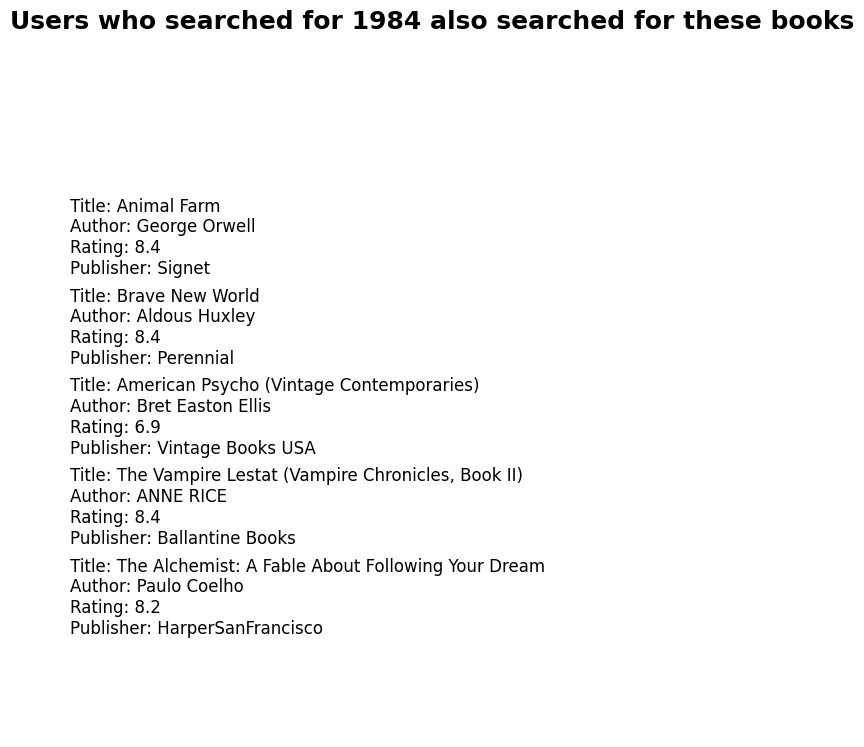

In [89]:
item_based_recommender('1984')

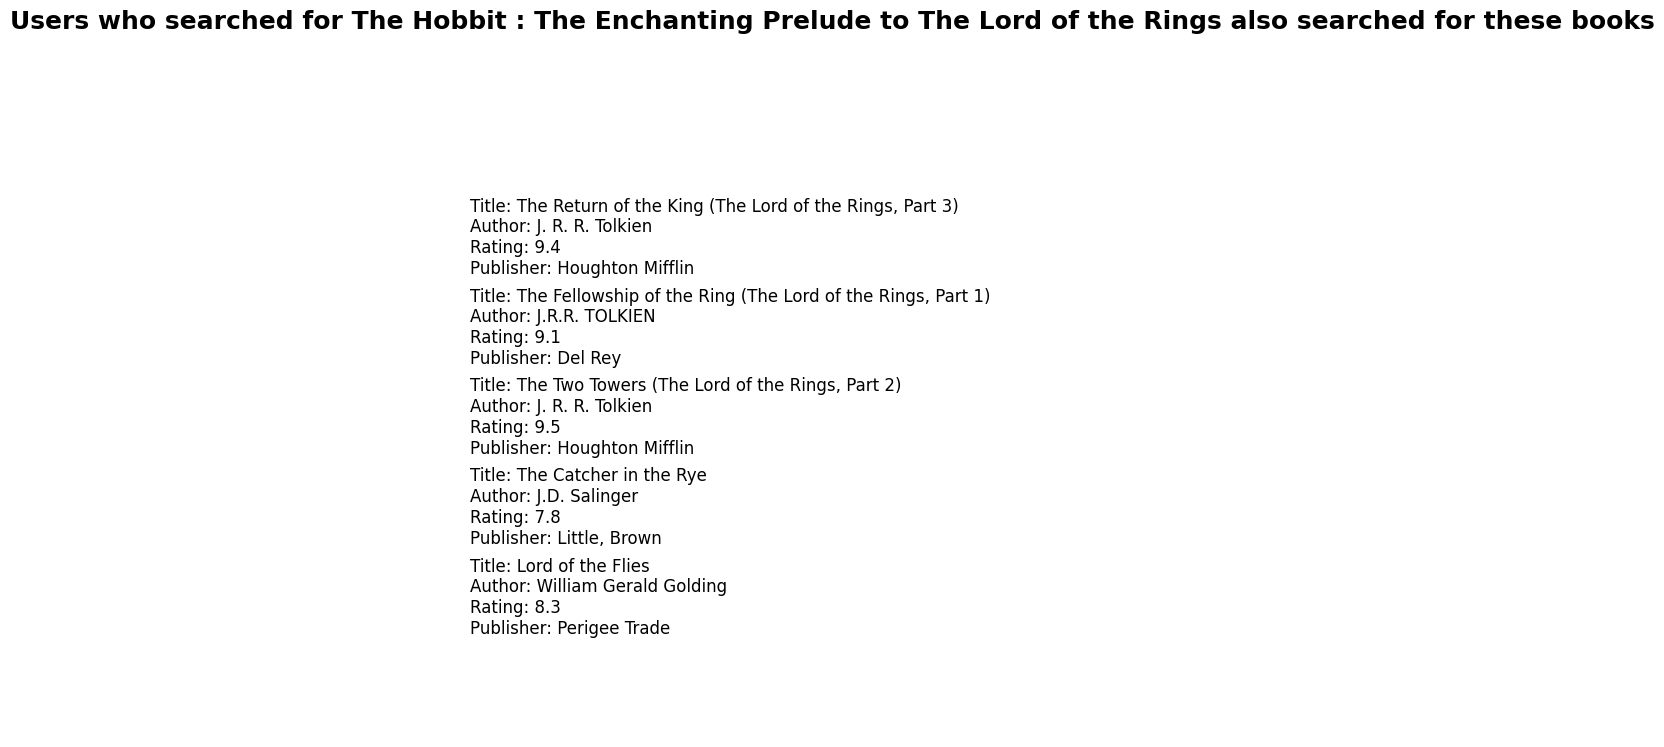

In [90]:
item_based_recommender('The Hobbit : The Enchanting Prelude to The Lord of the Rings')

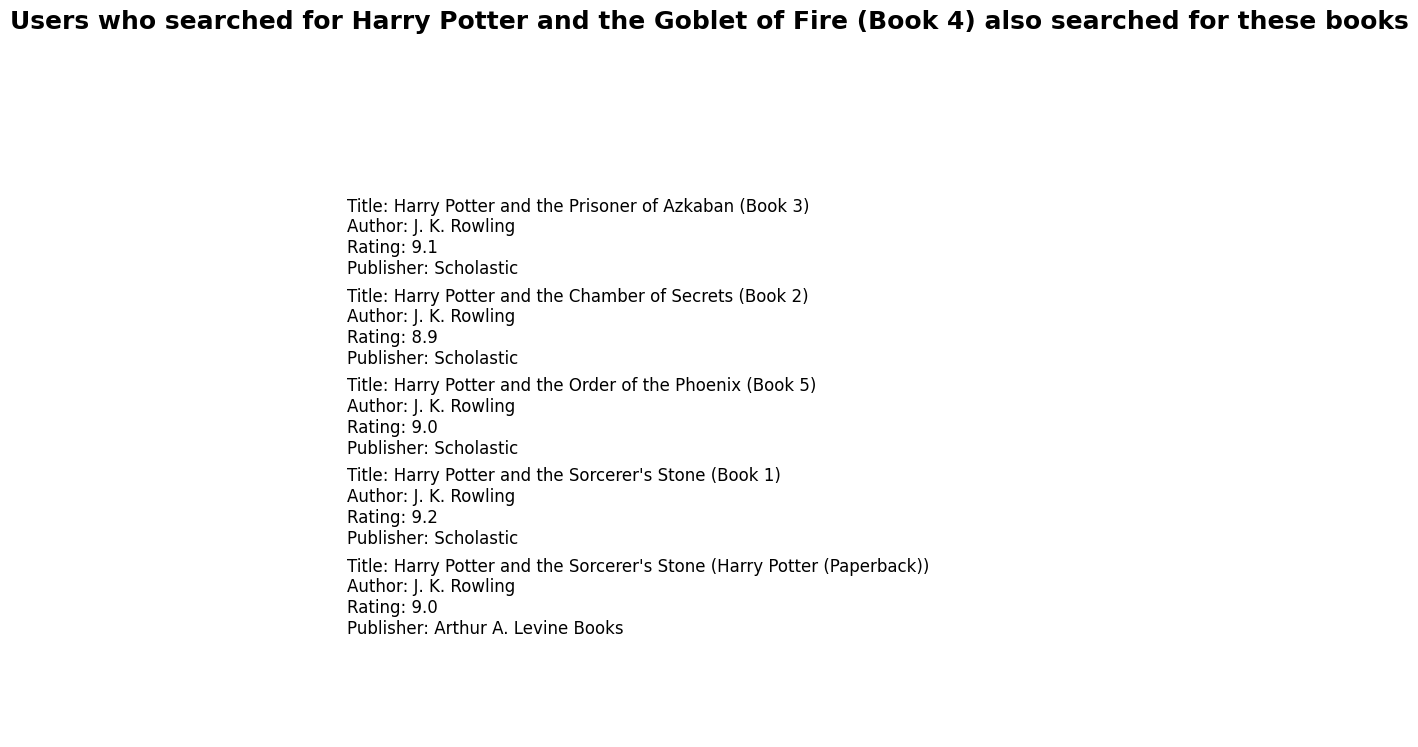

In [91]:
item_based_recommender('Harry Potter and the Goblet of Fire (Book 4)')

In [92]:
user_df = df.pivot_table(index=['User-ID'], columns=['Book-Title'], values='Book-Rating').fillna(0)
user_df

Book-Title  1984  1st to Die: A Novel  2010: Odyssey Two  2nd Chance  \
User-ID                                                                
254          9.0                  0.0                0.0         0.0   
638          0.0                  0.0                0.0         9.0   
643          0.0                  0.0                0.0         0.0   
882          0.0                  0.0                0.0         0.0   
929          0.0                  0.0                0.0         0.0   
...          ...                  ...                ...         ...   
277928       0.0                  0.0                0.0         0.0   
278026       0.0                  0.0                0.0         0.0   
278137       0.0                  0.0                0.0         0.0   
278188       0.0                  0.0                0.0         0.0   
278843       0.0                  0.0                0.0         0.0   

Book-Title  4 Blondes  84 Charing Cross Road  \
User-ID                                        
254               0.0                    0.0   
638               0.0                    0.0   
643               0.0                    0.0   
882               0.0                    0.0   
929               0.0                    0.0   
...               ...                    ...   
277928            0.0                    0.0   
278026            0.0                    0.0   
278137            0.0                    0.0   
278188            0.0                    0.0   
278843            0.0                    0.0   

Book-Title  A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash  \
User-ID                                                                                      
254                                                       0.0                                
638                                                       0.0                                
643                                                       0.0                                
882                                                       0.0                                
929                                                       0.0                                
...                                                       ...                                
277928                                                    0.0                                
278026                                                    0.0                                
278137                                                    0.0                                
278188                                                    0.0                                
278843                                                    0.0                                

Book-Title  A Bend in the Road  A Case of Need  \
User-ID                                          
254                        0.0             0.0   
638                        0.0             0.0   
643                        0.0             0.0   
882                        0.0             0.0   
929                        0.0             0.0   
...                        ...             ...   
277928                     0.0             0.0   
278026                     0.0             0.0   
278137                     0.0             0.0   
278188                     0.0             0.0   
278843                     0.0             0.0   

Book-Title  A Child Called \It\": One Child's Courage to Survive"  ...  \
User-ID                                                            ...   
254                                                       0.0      ...   
638                                                       0.0      ...   
643                                                       0.0      ...   
882                                                       0.0      ...   
929                                                       0.0      ...   
...                                           

In [93]:
cosine_similarity(user_df).shape

(2106, 2106)

In [94]:
cosine_sim = cosine_similarity(user_df)

In [95]:
user_sim_df = pd.DataFrame(cosine_sim)
# Set the index and column name to user Ids
user_sim_df.index = list(user_df.index)
user_sim_df.columns = list(user_df.index)
user_sim_df

254       638     643       882     929     1025      1211    \
254     1.000000  0.000000     0.0  0.000000     0.0     0.0  0.000000   
638     0.000000  1.000000     0.0  0.142724     0.0     0.0  0.214917   
643     0.000000  0.000000     1.0  0.000000     0.0     0.0  0.000000   
882     0.000000  0.142724     0.0  1.000000     0.0     0.0  0.332045   
929     0.000000  0.000000     0.0  0.000000     1.0     0.0  0.000000   
...          ...       ...     ...       ...     ...     ...       ...   
277928  0.000000  0.000000     0.0  0.000000     0.0     0.0  0.000000   
278026  0.000000  0.000000     0.0  0.000000     0.0     0.0  0.000000   
278137  0.000000  0.083708     0.0  0.000000     0.0     0.0  0.000000   
278188  0.000000  0.000000     0.0  0.000000     0.0     0.0  0.000000   
278843  0.115271  0.000000     0.0  0.000000     0.0     0.0  0.000000   

        1435      1674     1733    ...    277195    277378    277427  277478  \
254        0.0  0.103346  0.00000  ...  0.089434  0.109042  0.000000     0.0   
638        0.0  0.000000  0.00000  ...  0.000000  0.154947  0.132518     0.0   
643        0.0  0.000000  0.00000  ...  0.000000  0.000000  0.000000     0.0   
882        0.0  0.000000  0.06610  ...  0.000000  0.000000  0.068246     0.0   
929        0.0  0.000000  0.00000  ...  0.000000  0.000000  0.000000     0.0   
...        ...       ...      ...  ...       ...       ...       ...     ...   
277928     0.0  0.000000  0.00000  ...  0.000000  0.000000  0.000000     0.0   
278026     0.0  0.000000  0.00000  ...  0.000000  0.000000  0.081197     0.0   
278137     0.0  0.000000  0.00000  ...  0.000000  0.000000  0.000000     0.0   
278188     0.0  0.000000  0.00000  ...  0.000000  0.000000  0.000000     0.0   
278843     0.0  0.000000  0.17629  ...  0.178218  0.190131  0.000000     0.0   

          277639    277928  278026    278137  278188    278843  
254     0.000000  0.000000     0.0  0.000000     0.0  0.115271  
638     0.074449  0.000000     0.0  0.083708     0.0  0.000000  
643     0.000000  0.000000     0.0  0.000000     0.0  0.000000  
882     0.000000  0.000000     0.0  0.000000     0.0  0.000000  
929     0.000000  0.000000     0.0  0.000000     0.0  0.000000  
...          ...       ...     ...       ...     ...       ...  
277928  0.000000  1.000000     0.0  0.000000     0.0  0.185559  
278026  0.063357  0.000000     1.0  0.000000     0.0  0.000000  
278137  0.000000  0.000000     0.0  1.000000     0.0  0.000000  
278188  0.000000  0.000000     0.0  0.000000     1.0  0.000000  
278843  0.000000  0.185559     0.0  0.000000     0.0  1.000000  

[2106 rows x 2106 columns]

In [96]:
index = np.where(user_sim_df.index == 254)[0][0]
index

0

In [97]:
user_sim_df.index[index]

254

In [98]:
user_sim_df[user_sim_df.index[index]]

254       1.000000
638       0.000000
643       0.000000
882       0.000000
929       0.000000
            ...   
277928    0.000000
278026    0.000000
278137    0.000000
278188    0.000000
278843    0.115271
Name: 254, Length: 2106, dtype: float64

In [99]:
sorted(list(enumerate(user_sim_df[user_sim_df.index[index]])),key=lambda x:x[1],reverse=True)[1:6]

[(1807, 0.5255884162645769),
 (1392, 0.5142332441826051),
 (931, 0.46071289345818284),
 (796, 0.4599441961130213),
 (44, 0.42704746519889875)]

In [100]:
sorted_sim_books = sorted(list(enumerate(user_sim_df[user_sim_df.index[index]])),key=lambda x:x[1],reverse=True)[1:11]

In [101]:
user_df.index[637]

87938

In [102]:
users = []
for i in sorted_sim_books:
    users.append(user_sim_df.index[i[0]])

In [103]:
users

[239423, 183088, 124876, 108243, 6431, 208141, 212088, 179978, 119858, 183061]

In [104]:
book_list = []
for i in users:
    book_list = book_list+list(df[df['User-ID']==i]['Book-Title'])

In [105]:
book_list

['How to Make an American Quilt',
 'Harry Potter and the Chamber of Secrets (Book 2)',
 'Harry Potter and the Prisoner of Azkaban (Book 3)',
 "Harry Potter and the Sorcerer's Stone (Book 1)",
 'The Golden Compass (His Dark Materials, Book 1)',
 'The Subtle Knife (His Dark Materials, Book 2)',
 'Harry Potter and the Chamber of Secrets (Book 2)',
 'Harry Potter and the Prisoner of Azkaban (Book 3)',
 'Harry Potter and the Goblet of Fire (Book 4)',
 "Harry Potter and the Sorcerer's Stone (Book 1)",
 'Harry Potter and the Chamber of Secrets (Book 2)',
 'Harry Potter and the Prisoner of Azkaban (Book 3)',
 'Harry Potter and the Goblet of Fire (Book 4)',
 "The Plains of Passage (Earth's Children (Paperback))",
 'The Valley of Horses',
 'Guilty Pleasures (Anita Blake Vampire Hunter (Paperback))',
 'American Gods',
 'Black House',
 'The Two Towers (The Lord of the Rings, Part 2)',
 "Harry Potter and the Sorcerer's Stone (Book 1)",
 'The Golden Compass (His Dark Materials, Book 1)',
 'The Subtl

In [106]:
set(book_list)

{'A Child Called \\It\\": One Child\'s Courage to Survive"',
 'A Man Named Dave: A Story of Triumph and Forgiveness',
 'A Separate Peace',
 'American Gods',
 'Animal Farm',
 'Beloved (Plume Contemporary Fiction)',
 'Black House',
 "Don't Sweat the Small Stuff and It's All Small Stuff : Simple Ways to Keep the Little Things from Taking Over Your Life (Don't Sweat the Small Stuff Series)",
 'Guilty Pleasures (Anita Blake Vampire Hunter (Paperback))',
 'Harry Potter and the Chamber of Secrets (Book 2)',
 'Harry Potter and the Goblet of Fire (Book 4)',
 'Harry Potter and the Order of the Phoenix (Book 5)',
 'Harry Potter and the Prisoner of Azkaban (Book 3)',
 "Harry Potter and the Sorcerer's Stone (Book 1)",
 'How to Make an American Quilt',
 'Life of Pi',
 'Nights in Rodanthe',
 'On Writing',
 'The Amazing Adventures of Kavalier &amp; Clay',
 'The Amber Spyglass (His Dark Materials, Book 3)',
 'The Drawing of the Three (The Dark Tower, Book 2)',
 'The Eyes of the Dragon',
 'The Fellowshi

In [107]:
len(set(book_list))

38

In [108]:
set(df[df['User-ID']==254]['Book-Title'])

{'1984',
 'American Gods',
 'Animal Farm',
 'Harry Potter and the Chamber of Secrets (Book 2)',
 'Harry Potter and the Goblet of Fire (Book 4)',
 'Harry Potter and the Prisoner of Azkaban (Book 3)',
 "Harry Potter and the Sorcerer's Stone (Book 1)",
 'Neverwhere',
 "She's Come Undone (Oprah's Book Club)",
 'Stardust',
 "The Bonesetter's Daughter",
 'The Dark Half',
 'The Fellowship of the Ring (The Lord of the Rings, Part 1)',
 'The Golden Compass (His Dark Materials, Book 1)',
 'The Secret Life of Bees',
 'The Subtle Knife (His Dark Materials, Book 2)'}

In [109]:
df[df['User-ID']==254]['Book-Title']

227                  She's Come Undone (Oprah's Book Club)
1104                               The Secret Life of Bees
4658      Harry Potter and the Chamber of Secrets (Book 2)
4659      Harry Potter and the Chamber of Secrets (Book 2)
5080     Harry Potter and the Prisoner of Azkaban (Book 3)
5081     Harry Potter and the Prisoner of Azkaban (Book 3)
5195          Harry Potter and the Goblet of Fire (Book 4)
8391                                            Neverwhere
8588                                         American Gods
9496                             The Bonesetter's Daughter
13486       Harry Potter and the Sorcerer's Stone (Book 1)
14507      The Golden Compass (His Dark Materials, Book 1)
14508      The Golden Compass (His Dark Materials, Book 1)
15140        The Subtle Knife (His Dark Materials, Book 2)
19253    The Fellowship of the Ring (The Lord of the Ri...
21474                                          Animal Farm
22473                                                 19

In [110]:
set(book_list)-set(df[df['User-ID']==243]['Book-Title'])

{'A Child Called \\It\\": One Child\'s Courage to Survive"',
 'A Man Named Dave: A Story of Triumph and Forgiveness',
 'A Separate Peace',
 'American Gods',
 'Animal Farm',
 'Beloved (Plume Contemporary Fiction)',
 'Black House',
 "Don't Sweat the Small Stuff and It's All Small Stuff : Simple Ways to Keep the Little Things from Taking Over Your Life (Don't Sweat the Small Stuff Series)",
 'Guilty Pleasures (Anita Blake Vampire Hunter (Paperback))',
 'Harry Potter and the Chamber of Secrets (Book 2)',
 'Harry Potter and the Goblet of Fire (Book 4)',
 'Harry Potter and the Order of the Phoenix (Book 5)',
 'Harry Potter and the Prisoner of Azkaban (Book 3)',
 "Harry Potter and the Sorcerer's Stone (Book 1)",
 'How to Make an American Quilt',
 'Life of Pi',
 'Nights in Rodanthe',
 'On Writing',
 'The Amazing Adventures of Kavalier &amp; Clay',
 'The Amber Spyglass (His Dark Materials, Book 3)',
 'The Drawing of the Three (The Dark Tower, Book 2)',
 'The Eyes of the Dragon',
 'The Fellowshi

In [111]:
final_books = sorted(set(book_list)-set(df[df['User-ID']==243]['Book-Title']))

In [112]:
final_books[0:5]

['A Child Called \\It\\": One Child\'s Courage to Survive"',
 'A Man Named Dave: A Story of Triumph and Forgiveness',
 'A Separate Peace',
 'American Gods',
 'Animal Farm']

In [113]:
final_books[5:10]

['Beloved (Plume Contemporary Fiction)',
 'Black House',
 "Don't Sweat the Small Stuff and It's All Small Stuff : Simple Ways to Keep the Little Things from Taking Over Your Life (Don't Sweat the Small Stuff Series)",
 'Guilty Pleasures (Anita Blake Vampire Hunter (Paperback))',
 'Harry Potter and the Chamber of Secrets (Book 2)']

## User Based Collaborative Filtering

In [114]:
def user_based_recommender(user_id):
    if user_id in df['User-ID'].values:
        user_df = df.pivot_table(index=['User-ID'], columns=['Book-Title'], values='Book-Rating').fillna(0)
        
        cosine_sim = cosine_similarity(user_df)
        user_sim_df = pd.DataFrame(cosine_sim)
        user_sim_df.index = list(user_df.index)
        user_sim_df.columns = list(user_df.index)
        index = np.where(user_sim_df.index == user_id)[0][0]
        sim_books = list(enumerate(user_sim_df[user_sim_df.index[index]]))
        sorted_sim_books = sorted(sim_books, key=lambda x: x[1], reverse=True)[1:50]
        
        users = []
        for i in sorted_sim_books:
            users.append(user_sim_df.index[i[0]])
            
        book_list = []
        for i in users:
            book_list = book_list + list(df[df['User-ID'] == i]['Book-Title'])
        
        final_books = sorted(set(book_list) - set(df[df['User-ID'] == user_id]['Book-Title']))
        
        recommended_books = final_books[:10]
        
        fig, axs = plt.subplots(5, 2, figsize=(18, 20))
        fig.suptitle('Recommendation for User ID: ' + str(user_id), size=22, fontweight='bold')
        
        for i, book in enumerate(recommended_books):
            row = i // 2
            col = i % 2
            axs[row, col].axis("off")
            axs[row, col].text(0.5, 0.5, '{}. {}\nAuthor: {}\nRating: {}\nPublisher: {}'.format(
                i + 1,
                book,
                df['Book-Author'][df['Book-Title'] == book].values[0],
                round(df[df['Book-Title'] == book]['Book-Rating'].mean(), 1),
                df['Publisher'][df['Book-Title'] == book].values[0]),
                fontsize=16, verticalalignment='center', wrap=True)
        
        fig.subplots_adjust(hspace=0.3, wspace=0.1)
        plt.show()
    else:
        random = pd.Series(df['User-ID'].unique()).sample(2).values
        print('Cannot find the user in the dataset, please check the spelling.\n')
        print('Try: \n')
        print('{}'.format(random[0]), '\n')
        print('{}'.format(random[1]), '\n')
        print('{}'.format(random[2]), '\n')


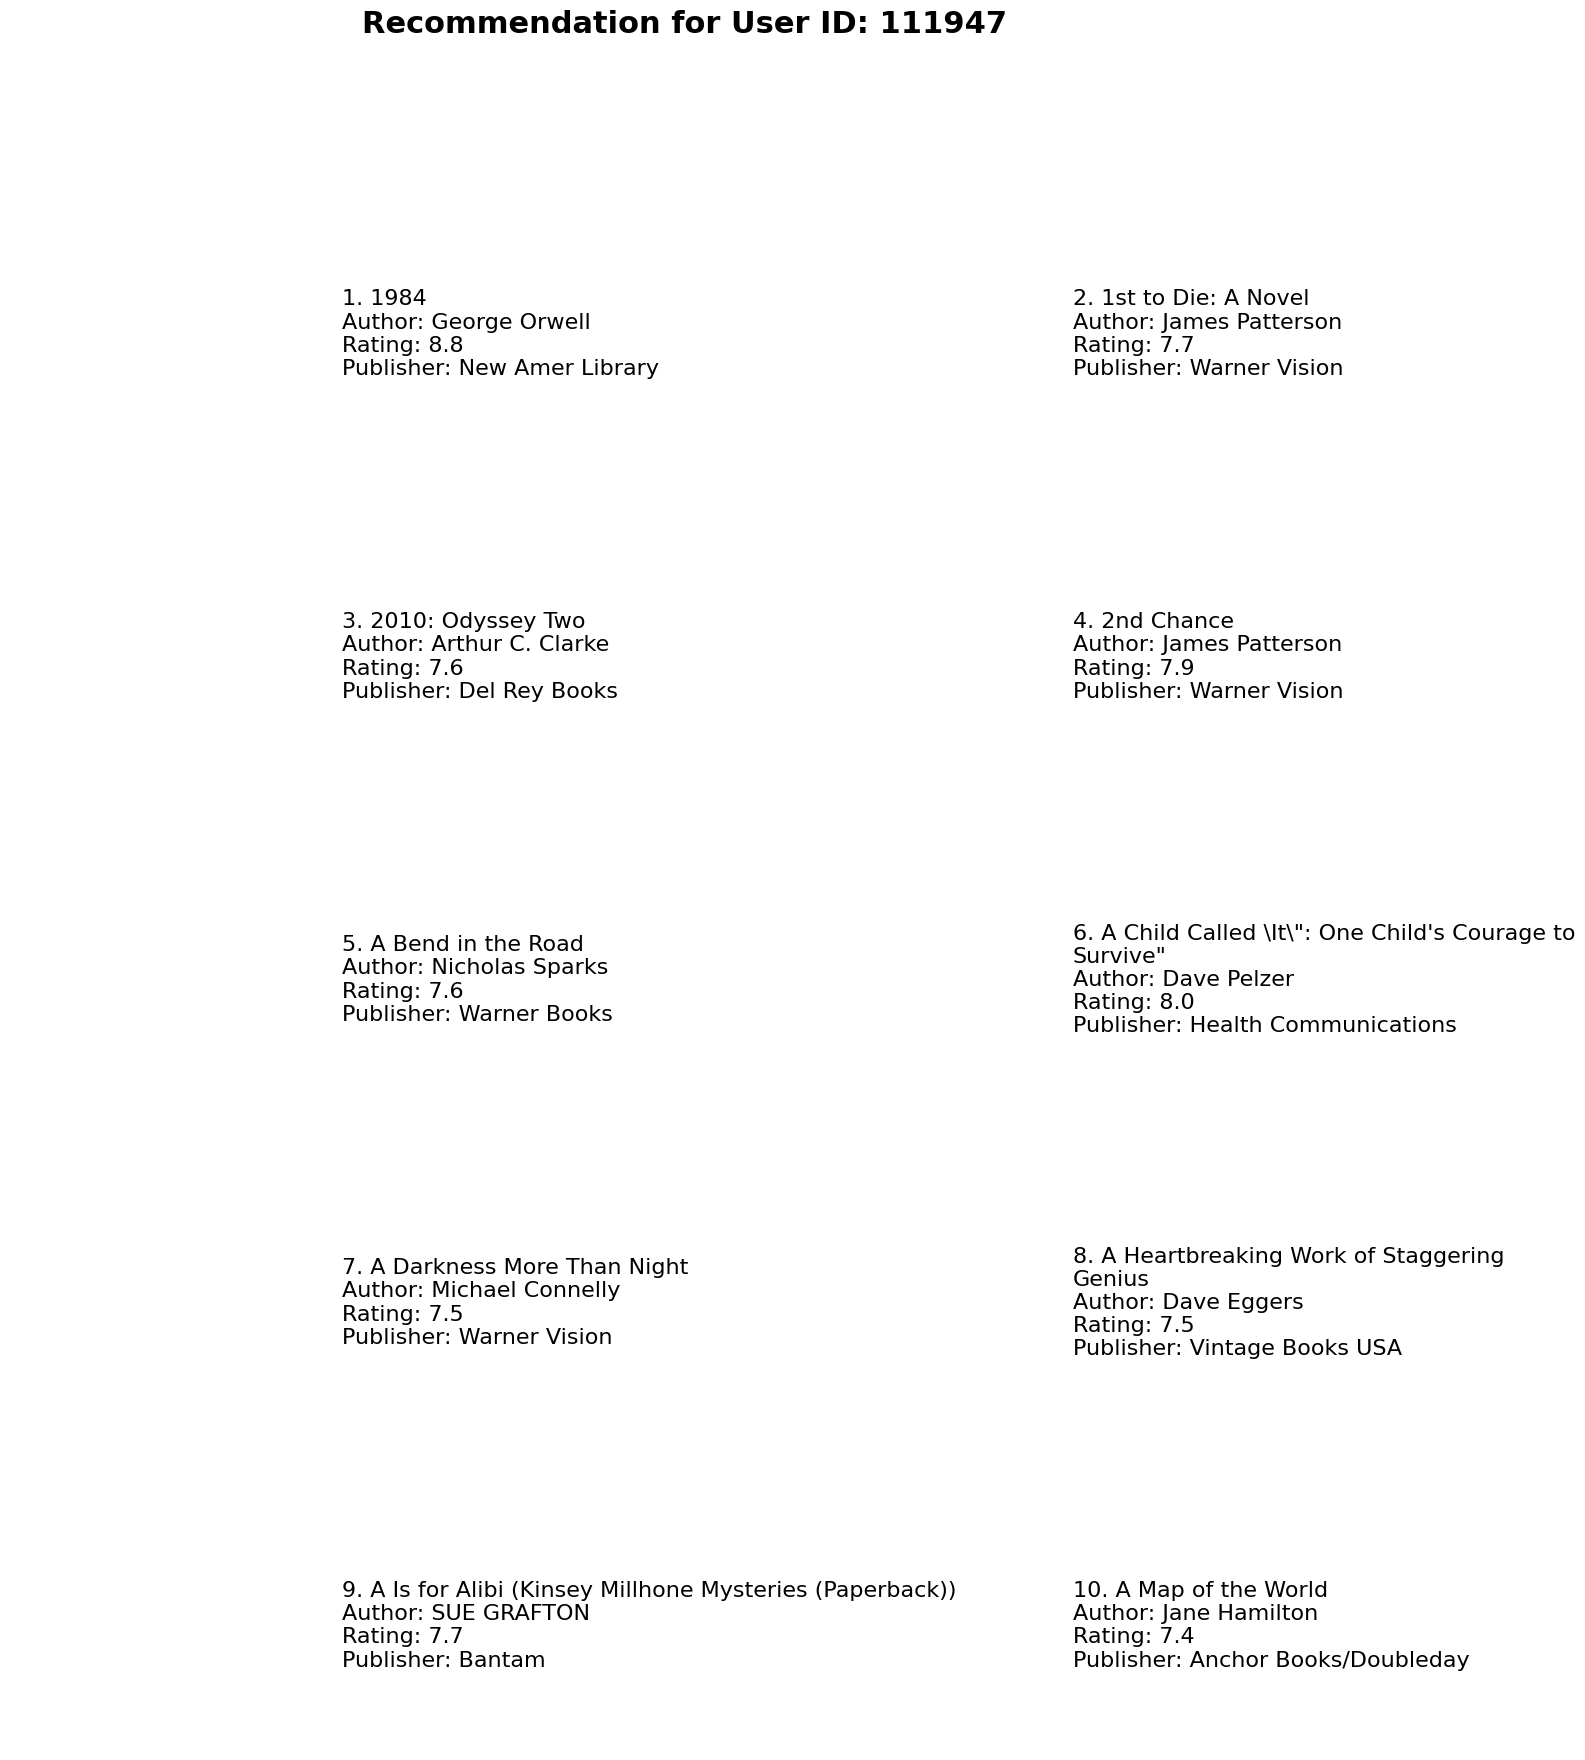

In [115]:
user_based_recommender(111947)

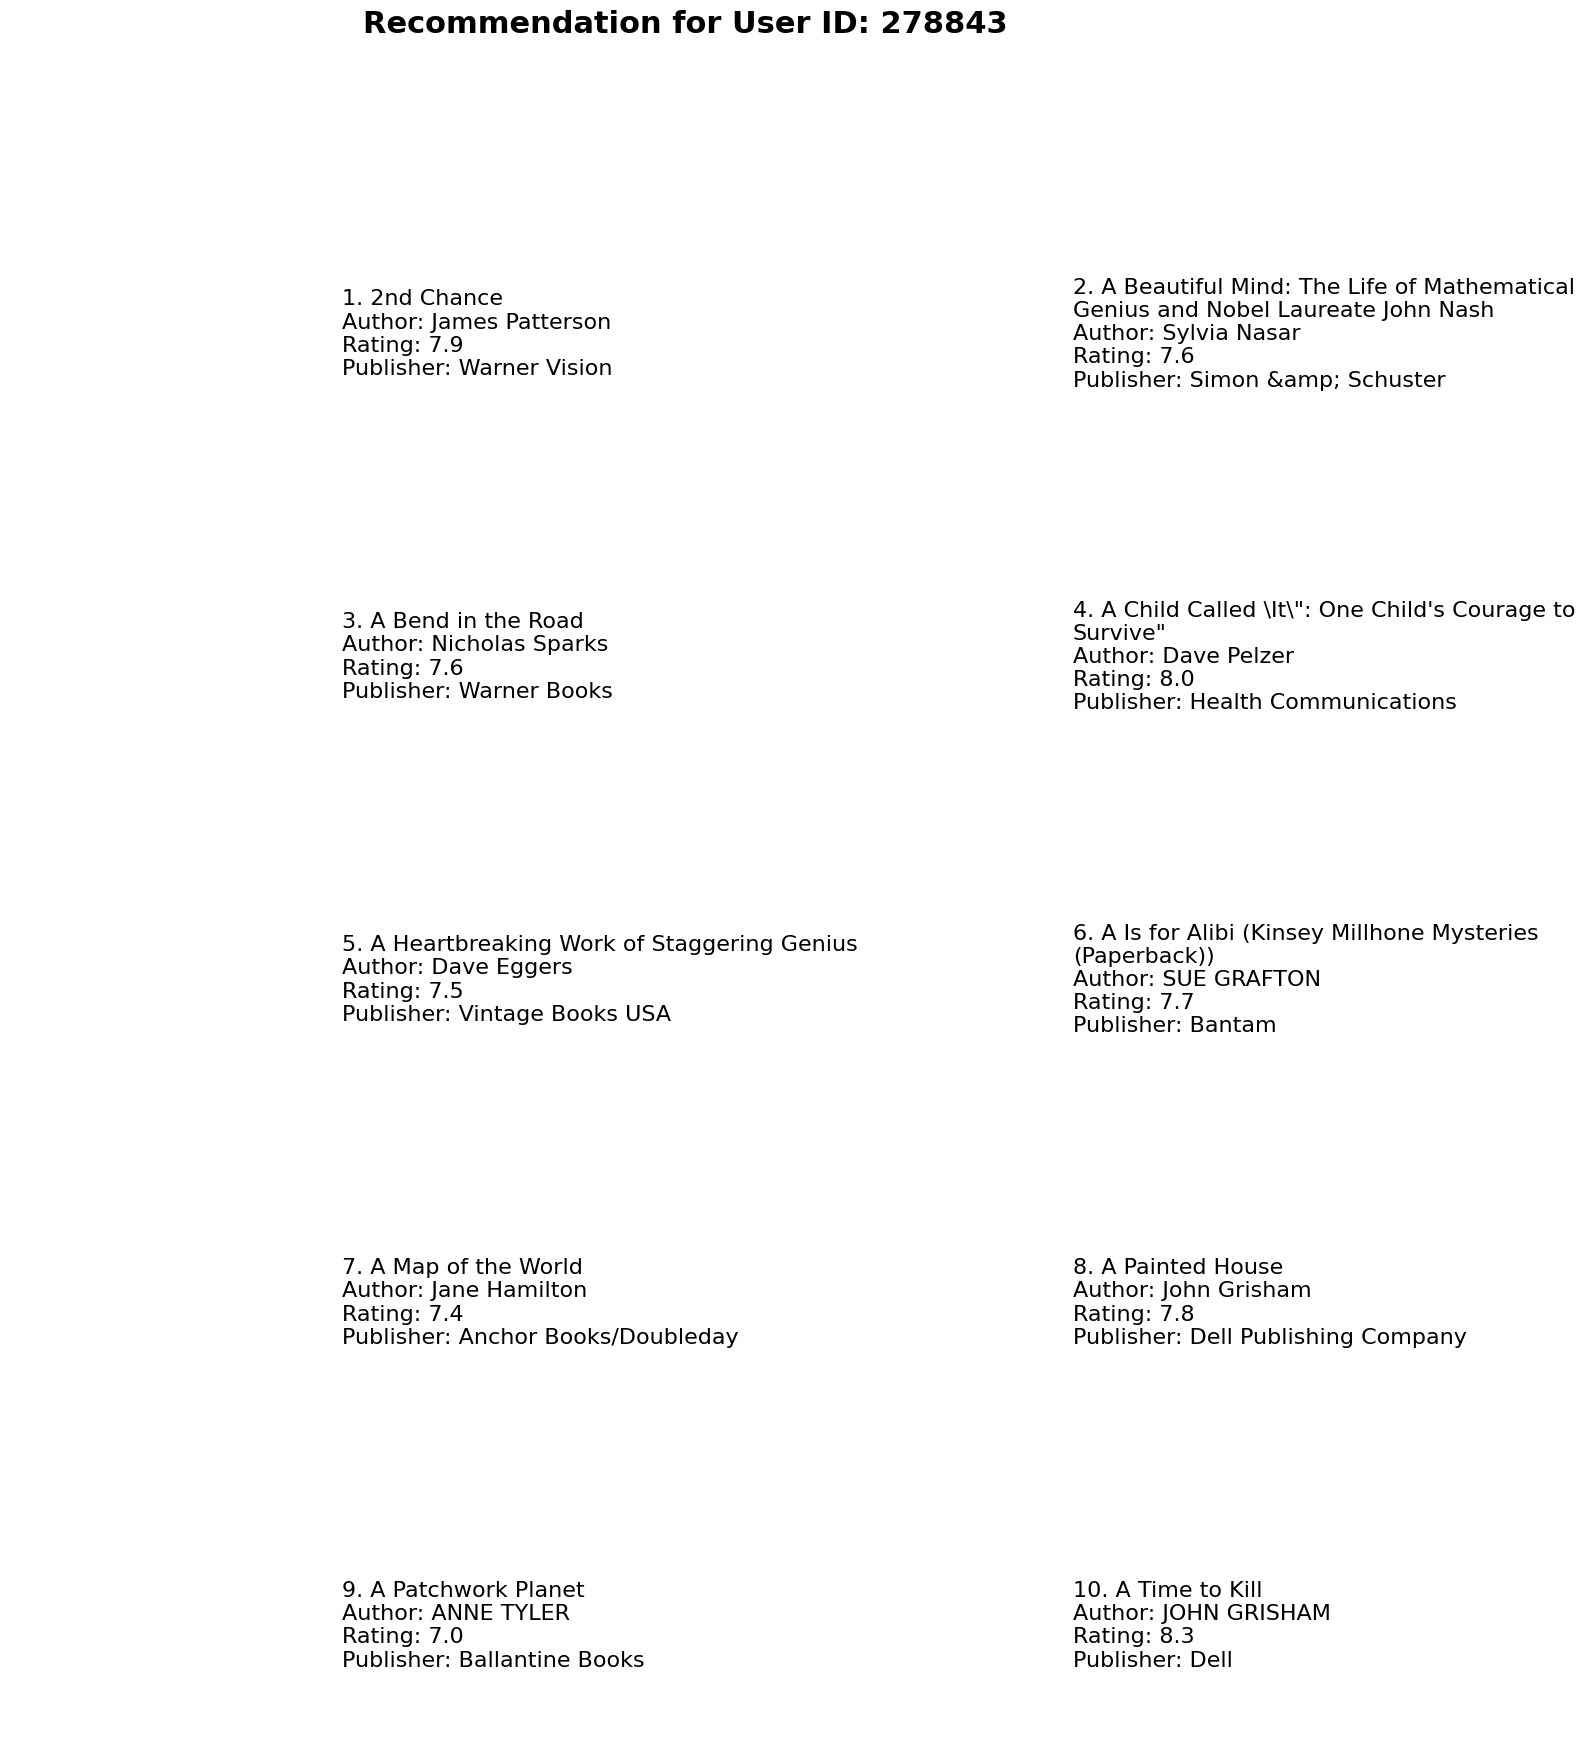

In [116]:
user_based_recommender(278843)

## Content-Based Collaborative Filtering
In this recommender system the content of the book (Title, Author, Publisher, Category etc) is used to find its similarity with other books. Then the books that are most likely to be similar are recommended.

### Title, Author, Publisher, Rating

In [117]:
def content_based_recommender(book_title):
    book_title = str(book_title)
    if book_title in df['Book-Title'].values:
        rating_counts = pd.DataFrame(df['Book-Title'].value_counts())
        rare_books = rating_counts[rating_counts['Book-Title'] <= 50].index
        common_books = df[~df['Book-Title'].isin(rare_books)]
        
        if book_title in rare_books:
            random = pd.Series(common_books['Book-Title'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try: \n')
            print('{}'.format(random[0]), '\n')
            print('{}'.format(random[1]), '\n')
        else:
            common_books = common_books.drop_duplicates(subset=['Book-Title'])
            common_books.reset_index(inplace=True)
            common_books['index'] = [i for i in range(common_books.shape[0])]
            target_cols = ['Book-Title', 'Book-Author', 'Book-Rating', 'Publisher']
            common_books['combined_features'] = [' '.join(common_books[target_cols].iloc[i,].astype(str).values) for i in range(common_books[target_cols].shape[0])]
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['combined_features'])
            cosine_sim = cosine_similarity(count_matrix)
            index = common_books[common_books['Book-Title'] == book_title]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books = sorted(sim_books, key=lambda x: x[1], reverse=True)[1:6]
            
            print('Book Details for "{}":'.format(book_title))
            print('----------------------------------------')
            print('Title: {}'.format(book_title))
            print('Author: {}'.format(df['Book-Author'][df['Book-Title'] == book_title].values[0]))
            print('Rating: {}'.format(round(df[df['Book-Title'] == book_title]['Book-Rating'].mean(), 1)))
            print('Publisher: {}'.format(df['Publisher'][df['Book-Title'] == book_title].values[0]))
            print()
            
            books = []
            for i in range(len(sorted_sim_books)):
                books.append(common_books[common_books['index'] == sorted_sim_books[i][0]]['Book-Title'].item())
            
            print('\n\033[1mYou may also like these books:\033[0m')
            print('----------------------------------------')

            for i in range(len(books)):
                print('{}. {}'.format(i + 1, books[i]))
                print('   Author: {}'.format(df['Book-Author'][df['Book-Title'] == books[i]].values[0]))
                print('   Rating: {}'.format(round(df[df['Book-Title'] == books[i]]['Book-Rating'].mean(), 1)))
                print('   Publisher: {}'.format(df['Publisher'][df['Book-Title'] == books[i]].values[0]))
                print()
    else:
        print('Cannot find the book in the dataset, please check the spelling.')




In [118]:
content_based_recommender('Harry Potter and the Order of the Phoenix (Book 5)')

Book Details for "Harry Potter and the Order of the Phoenix (Book 5)":
----------------------------------------
Title: Harry Potter and the Order of the Phoenix (Book 5)
Author: J. K. Rowling
Rating: 9.0
Publisher: Scholastic


You may also like these books:
----------------------------------------
1. Harry Potter and the Chamber of Secrets (Book 2)
   Author: J. K. Rowling
   Rating: 8.9
   Publisher: Scholastic

2. Harry Potter and the Prisoner of Azkaban (Book 3)
   Author: J. K. Rowling
   Rating: 9.1
   Publisher: Scholastic

3. Harry Potter and the Goblet of Fire (Book 4)
   Author: J. K. Rowling
   Rating: 9.2
   Publisher: Scholastic

4. Harry Potter and the Sorcerer's Stone (Book 1)
   Author: J. K. Rowling
   Rating: 9.2
   Publisher: Scholastic

5. Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
   Author: J. K. Rowling
   Rating: 9.0
   Publisher: Arthur A. Levine Books



In [119]:
content_based_recommender('The Hobbit : The Enchanting Prelude to The Lord of the Rings')

Book Details for "The Hobbit : The Enchanting Prelude to The Lord of the Rings":
----------------------------------------
Title: The Hobbit : The Enchanting Prelude to The Lord of the Rings
Author: J.R.R. TOLKIEN
Rating: 9.0
Publisher: Del Rey


You may also like these books:
----------------------------------------
1. The Fellowship of the Ring (The Lord of the Rings, Part 1)
   Author: J.R.R. TOLKIEN
   Rating: 9.1
   Publisher: Del Rey

2. The Two Towers (The Lord of the Rings, Part 2)
   Author: J. R. R. Tolkien
   Rating: 9.5
   Publisher: Houghton Mifflin

3. Wicked: The Life and Times of the Wicked Witch of the West
   Author: Gregory Maguire
   Rating: 7.9
   Publisher: Regan Books

4. The Hitchhiker's Guide to the Galaxy
   Author: Douglas Adams
   Rating: 8.5
   Publisher: Harmony

5. The Catcher in the Rye
   Author: J.D. Salinger
   Rating: 7.8
   Publisher: Little, Brown



In [120]:
content_based_recommender('The Testament')

Book Details for "The Testament":
----------------------------------------
Title: The Testament
Author: John Grisham
Rating: 7.7
Publisher: Doubleday Books


You may also like these books:
----------------------------------------
1. The Brethren
   Author: JOHN GRISHAM
   Rating: 7.8
   Publisher: Doubleday

2. The Chamber
   Author: John Grisham
   Rating: 7.8
   Publisher: Doubleday Books

3. The Runaway Jury
   Author: JOHN GRISHAM
   Rating: 7.8
   Publisher: Doubleday

4. Skipping Christmas
   Author: JOHN GRISHAM
   Rating: 7.6
   Publisher: Doubleday

5. The Rainmaker
   Author: JOHN GRISHAM
   Rating: 7.6
   Publisher: Dell



## Comparison of All Recommenders

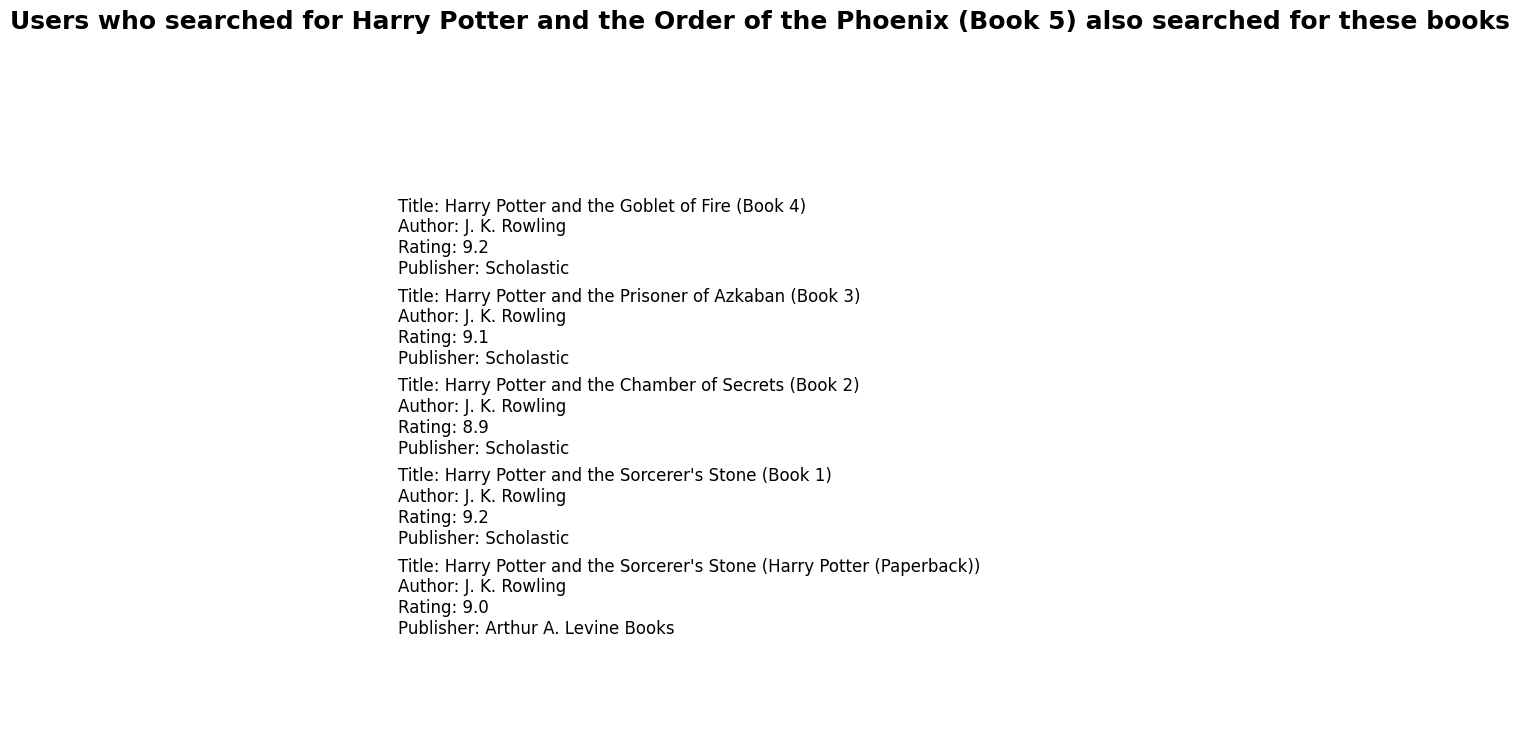

In [121]:
item_based_recommender('Harry Potter and the Order of the Phoenix (Book 5)')

In [122]:
content_based_recommender('Harry Potter and the Order of the Phoenix (Book 5)')

Book Details for "Harry Potter and the Order of the Phoenix (Book 5)":
----------------------------------------
Title: Harry Potter and the Order of the Phoenix (Book 5)
Author: J. K. Rowling
Rating: 9.0
Publisher: Scholastic


You may also like these books:
----------------------------------------
1. Harry Potter and the Chamber of Secrets (Book 2)
   Author: J. K. Rowling
   Rating: 8.9
   Publisher: Scholastic

2. Harry Potter and the Prisoner of Azkaban (Book 3)
   Author: J. K. Rowling
   Rating: 9.1
   Publisher: Scholastic

3. Harry Potter and the Goblet of Fire (Book 4)
   Author: J. K. Rowling
   Rating: 9.2
   Publisher: Scholastic

4. Harry Potter and the Sorcerer's Stone (Book 1)
   Author: J. K. Rowling
   Rating: 9.2
   Publisher: Scholastic

5. Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
   Author: J. K. Rowling
   Rating: 9.0
   Publisher: Arthur A. Levine Books

